# Adversarial Learning against Intrusion Detection Systems

In this notebook, we examine the feasibility of adversarial learning in the context of Intrusion Detection. We use the CICIDS2017 dataset and create a learning model to perform binary classification against this. We then study how this holds against FGSM attacks, and the amount of perturbation required to create a false result. We then explore how different parameter counts hold against this attack vector, to assess the robustness of the feature sets being used for learning.

In [ ]:
!pip install -q tensorflow==2.0.0b1
# Install bleeding edge version of cleverhans
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans

import cleverhans
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print("\nTensorflow Version: " + tf.__version__)
print("Cleverhans Version: " + cleverhans.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

     |████████████████████████████████| 87.9MB 53kB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 501kB 48.2MB/s 
     |████████████████████████████████| 3.1MB 49.2MB/s 
  Cloning https://github.com/tensorflow/cleverhans.git to /tmp/pip-install-vgb3t4wh/cleverhans
  Running command git clone -q https://github.com/tensorflow/cleverhans.git /tmp/pip-install-vgb3t4wh/cleverhans
     |████████████████████████████████| 163kB 12.2MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
  Created wheel for cleverhans: filename=cleverhans-3.0.1-cp36-none-any.whl size=262570 sha256=6d42f7f809a3cb8347bafaf7b9eecc3bc86ced5f96a742e850f9bde0780af21b
  Stored in directory: /tmp/pip-ephem-wheel-cache-u8ts0re7/wheels/6e/59/ec/723a6f654aaf62c8c40f0f0850fdf71a4948598697f56c3bfa
Successfully built cleverhans


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 


Tensorflow Version: 2.0.0-beta1
Cleverhans Version: 3.0.1-15447acccf2628751c1e44ee30e141ec
GPU Available:  False


/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

## GPUs


In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

## Load in the Dataset

We will load in the CICIDS 2017 - this can be used either based on the binary class or the multi-class label.

In [ ]:
import pandas as pd
import sys as sys



from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from google.colab import drive
drive.mount('./mount')
print("Drive Mounted")

#dataset = pd.read_csv('mount/My Drive/Colab Notebooks/CICIDS2017/Friday-WorkingHours-Morning.pcap_ISCX.csv')
#dataset = pd.read_csv('mount/My Drive/Colab Notebooks/CICIDS2017/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')

dataset = pd.read_csv('mount/My Drive/Colab Notebooks/CICIDS2017/BalancedInfiltration.csv')


dataset = dataset.iloc[0:72,:]

#dataset = pd.read_csv('mount/My Drive/Colab Notebooks/network_data/CICIDS2017_dataset.csv')
#dataset = pd.read_csv('mount/My Drive/Colab Notebooks/network_data/CICIDS2017_FeatureImportancesWithoutRankings.csv')
print ("Dataset Shape", dataset.shape)
print(dataset)
# Creating X and Y from the dataset
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(dataset[' Label'])
Y_attack = le.transform(dataset[' Label']) # multi-class 

#print(list(le.classes_))
#print(np.unique(Y_attack))

print("Dropping Flow Bytes and Flow Packets")
dataset = dataset.drop(columns='Flow Bytes/s')
dataset = dataset.drop(columns=' Flow Packets/s')

print("Big Differences")
# 'Fwd PSH Flags'
# ' ACK Flag Count'
# 'Bwd Packet Length Max'
# ' Max Packet Length'
# ' Packet Length Mean'

print(dataset.columns)





# Transform Objects to Digits
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for column_name in dataset.columns:
        if dataset[column_name].dtype == object:
            print(dataset[column_name])
            dataset[column_name] = le.fit_transform(dataset[column_name])
        else:
            pass


Y_class = dataset.iloc[:,-1].values # binary
X = dataset.iloc[:,0:80].values



X = X.astype(float)

# Performing scale data
scaler = MinMaxScaler().fit(X)
X_scaled = np.array(scaler.transform(X))

Mounted at ./mount
Drive Mounted
Dataset Shape (72, 79)
     Destination Port   Flow Duration  ...   Idle Min         Label
0                  22             166  ...          0        BENIGN
1               60148              83  ...          0        BENIGN
2                 123           99947  ...          0        BENIGN
3                 123           37017  ...          0        BENIGN
4                   0       111161336  ...    5700287        BENIGN
..                ...             ...  ...        ...           ...
67                444        99912925  ...   20900000  Infiltration
68                444       111406728  ...   54800000  Infiltration
69                444        79492070  ...   18300000  Infiltration
70                444        48450959  ...          0  Infiltration
71                444        56538478  ...   56500000  Infiltration

[72 rows x 79 columns]
Dropping Flow Bytes and Flow Packets
Big Differences
Index([' Destination Port', ' Flow Duration', ' Tot

## kfold



In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)


## Binary Classification

Dropping  Avg Bwd Segment Size
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.7076 - accuracy: 0.4737
Epoch 2/10
57/57 [==============================] - 0s 158us/sample - loss: 0.6378 - accuracy: 0.8070
Epoch 3/10
57/57 [==============================] - 0s 137us/sample - loss: 0.5873 - accuracy: 0.9123
Epoch 4/10
57/57 [==============================] - 0s 135us/sample - loss: 0.5440 - accuracy: 0.9474
Epoch 5/10
57/57 [==============================] - 0s 132us/sample - loss: 0.5043 - accuracy: 0.9474
Epoch 6/10
57/57 [==============================] - 0s 210us/sample - loss: 0.4688 - accuracy: 0.9123
Epoch 7/10
57/57 [==============================] - 0s 110us/sample - loss: 0.4327 - accuracy: 0.9123
Epoch 8/10
57/57 [==============================] - 0s 78us/sample - loss: 0.3999 - accuracy: 0.9123
Epoch 9/10
57/57 [========================

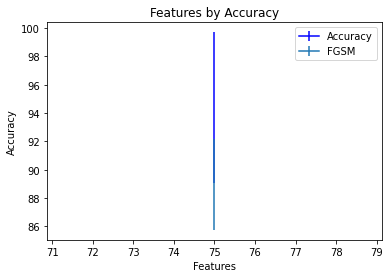

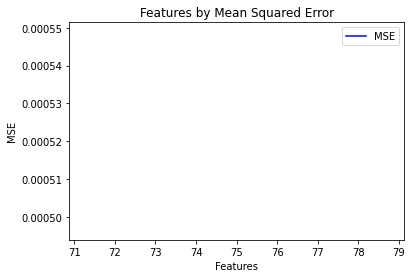

Dropping FIN Flag Count
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.6991 - accuracy: 0.5789
Epoch 2/10
57/57 [==============================] - 0s 132us/sample - loss: 0.6149 - accuracy: 0.9298
Epoch 3/10
57/57 [==============================] - 0s 131us/sample - loss: 0.5480 - accuracy: 0.9298
Epoch 4/10
57/57 [==============================] - 0s 97us/sample - loss: 0.4899 - accuracy: 0.9298
Epoch 5/10
57/57 [==============================] - 0s 123us/sample - loss: 0.4428 - accuracy: 0.9298
Epoch 6/10
57/57 [==============================] - 0s 88us/sample - loss: 0.4004 - accuracy: 0.9474
Epoch 7/10
57/57 [==============================] - 0s 101us/sample - loss: 0.3627 - accuracy: 0.9474
Epoch 8/10
57/57 [==============================] - 0s 86us/sample - loss: 0.3256 - accuracy: 0.9474
Epoch 9/10
57/57 [==============================] - 0s 96us/sample - loss: 0.2934 - accuracy: 0.9649
Epoch 10/10
15/15 [=========================

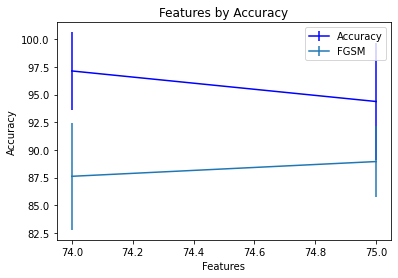

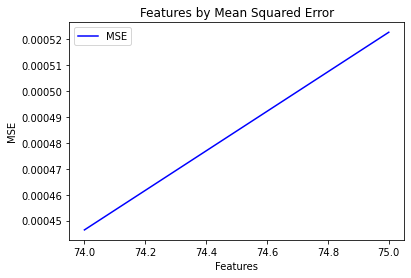

Dropping  Subflow Bwd Bytes
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.6554 - accuracy: 0.8070
Epoch 2/10
57/57 [==============================] - 0s 100us/sample - loss: 0.5866 - accuracy: 0.8596
Epoch 3/10
57/57 [==============================] - 0s 78us/sample - loss: 0.5291 - accuracy: 0.8947
Epoch 4/10
57/57 [==============================] - 0s 80us/sample - loss: 0.4827 - accuracy: 0.9123
Epoch 5/10
57/57 [==============================] - 0s 75us/sample - loss: 0.4398 - accuracy: 0.9298
Epoch 6/10
57/57 [==============================] - 0s 80us/sample - loss: 0.3997 - accuracy: 0.9474
Epoch 7/10
57/57 [==============================] - 0s 72us/sample - loss: 0.3626 - accuracy: 0.9649
Epoch 8/10
57/57 [==============================] - 0s 72us/sample - loss: 0.3272 - accuracy: 0.9825
Epoch 9/10
57/57 [==============================] - 0s 72us/sample - loss: 0.2919 - accuracy: 0.9825
Epoch 10/10
15/15 [========================

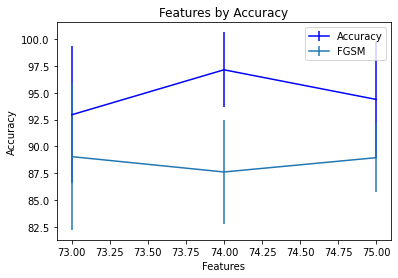

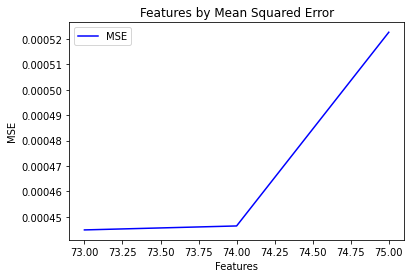

Dropping  Bwd Packet Length Mean
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.6993 - accuracy: 0.4737
Epoch 2/10
57/57 [==============================] - 0s 143us/sample - loss: 0.6184 - accuracy: 0.7895
Epoch 3/10
57/57 [==============================] - 0s 137us/sample - loss: 0.5546 - accuracy: 0.8596
Epoch 4/10
57/57 [==============================] - 0s 126us/sample - loss: 0.5074 - accuracy: 0.9123
Epoch 5/10
57/57 [==============================] - 0s 118us/sample - loss: 0.4603 - accuracy: 0.9123
Epoch 6/10
57/57 [==============================] - 0s 123us/sample - loss: 0.4235 - accuracy: 0.9298
Epoch 7/10
57/57 [==============================] - 0s 115us/sample - loss: 0.3874 - accuracy: 0.9298
Epoch 8/10
57/57 [==============================] - 0s 84us/sample - loss: 0.3541 - accuracy: 0.9298
Epoch 9/10
57/57 [==============================] - 0s 86us/sample - loss: 0.3222 - accuracy: 0.9298
Epoch 10/10
15/15 [==============

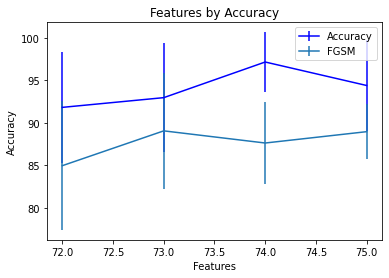

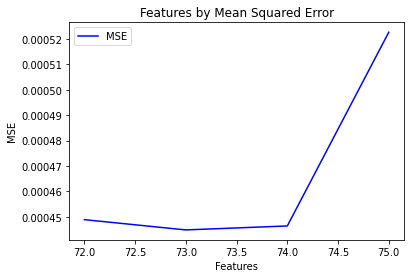

Dropping Bwd Packet Length Max
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.6645 - accuracy: 0.5263
Epoch 2/10
57/57 [==============================] - 0s 80us/sample - loss: 0.5959 - accuracy: 0.7018
Epoch 3/10
57/57 [==============================] - 0s 90us/sample - loss: 0.5405 - accuracy: 0.8246
Epoch 4/10
57/57 [==============================] - 0s 99us/sample - loss: 0.4934 - accuracy: 0.9298
Epoch 5/10
57/57 [==============================] - 0s 77us/sample - loss: 0.4508 - accuracy: 0.9649
Epoch 6/10
57/57 [==============================] - 0s 120us/sample - loss: 0.4121 - accuracy: 0.9649
Epoch 7/10
57/57 [==============================] - 0s 85us/sample - loss: 0.3757 - accuracy: 0.9825
Epoch 8/10
57/57 [==============================] - 0s 101us/sample - loss: 0.3414 - accuracy: 0.9825
Epoch 9/10
57/57 [==============================] - 0s 75us/sample - loss: 0.3096 - accuracy: 0.9825
Epoch 10/10
15/15 [====================

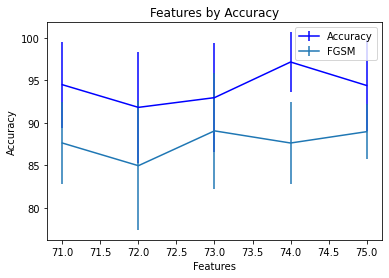

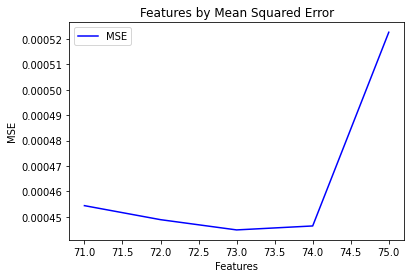

Dropping  Init_Win_bytes_backward
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 1ms/sample - loss: 0.7466 - accuracy: 0.3158
Epoch 2/10
57/57 [==============================] - 0s 149us/sample - loss: 0.6665 - accuracy: 0.7895
Epoch 3/10
57/57 [==============================] - 0s 141us/sample - loss: 0.6073 - accuracy: 0.8772
Epoch 4/10
57/57 [==============================] - 0s 107us/sample - loss: 0.5540 - accuracy: 0.8596
Epoch 5/10
57/57 [==============================] - 0s 87us/sample - loss: 0.5124 - accuracy: 0.8772
Epoch 6/10
57/57 [==============================] - 0s 74us/sample - loss: 0.4748 - accuracy: 0.8772
Epoch 7/10
57/57 [==============================] - 0s 200us/sample - loss: 0.4439 - accuracy: 0.8772
Epoch 8/10
57/57 [==============================] - 0s 116us/sample - loss: 0.4153 - accuracy: 0.8947
Epoch 9/10
57/57 [==============================] - 0s 93us/sample - loss: 0.3866 - accuracy: 0.8947
Epoch 10/10
15/15 [==============

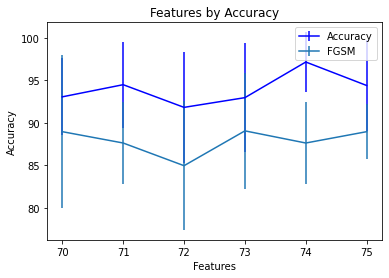

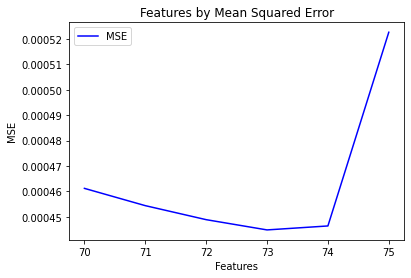

Dropping  Bwd IAT Min
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 1ms/sample - loss: 0.7012 - accuracy: 0.4737
Epoch 2/10
57/57 [==============================] - 0s 87us/sample - loss: 0.6298 - accuracy: 0.7368
Epoch 3/10
57/57 [==============================] - 0s 86us/sample - loss: 0.5750 - accuracy: 0.9123
Epoch 4/10
57/57 [==============================] - 0s 83us/sample - loss: 0.5225 - accuracy: 0.9298
Epoch 5/10
57/57 [==============================] - 0s 98us/sample - loss: 0.4724 - accuracy: 0.9825
Epoch 6/10
57/57 [==============================] - 0s 93us/sample - loss: 0.4267 - accuracy: 0.9825
Epoch 7/10
57/57 [==============================] - 0s 122us/sample - loss: 0.3855 - accuracy: 0.9825
Epoch 8/10
57/57 [==============================] - 0s 80us/sample - loss: 0.3458 - accuracy: 0.9825
Epoch 9/10
57/57 [==============================] - 0s 87us/sample - loss: 0.3093 - accuracy: 0.9825
Epoch 10/10
15/15 [==============================

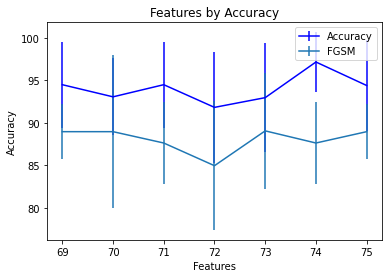

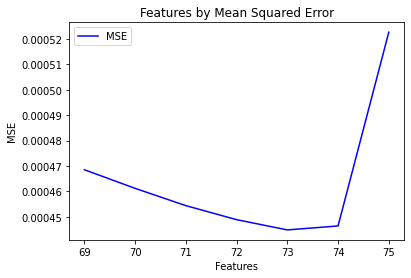

Dropping Fwd Packets/s
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 1ms/sample - loss: 0.7630 - accuracy: 0.4737
Epoch 2/10
57/57 [==============================] - 0s 76us/sample - loss: 0.6625 - accuracy: 0.6140
Epoch 3/10
57/57 [==============================] - 0s 91us/sample - loss: 0.5916 - accuracy: 0.8421
Epoch 4/10
57/57 [==============================] - 0s 87us/sample - loss: 0.5346 - accuracy: 0.8947
Epoch 5/10
57/57 [==============================] - 0s 78us/sample - loss: 0.4885 - accuracy: 0.9123
Epoch 6/10
57/57 [==============================] - 0s 197us/sample - loss: 0.4471 - accuracy: 0.9123
Epoch 7/10
57/57 [==============================] - 0s 94us/sample - loss: 0.4089 - accuracy: 0.9123
Epoch 8/10
57/57 [==============================] - 0s 81us/sample - loss: 0.3745 - accuracy: 0.9123
Epoch 9/10
57/57 [==============================] - 0s 78us/sample - loss: 0.3435 - accuracy: 0.9123
Epoch 10/10
15/15 [=============================

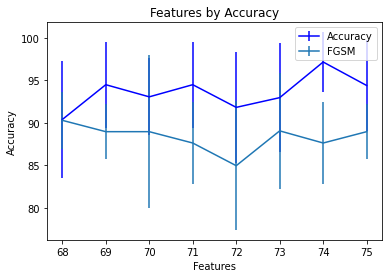

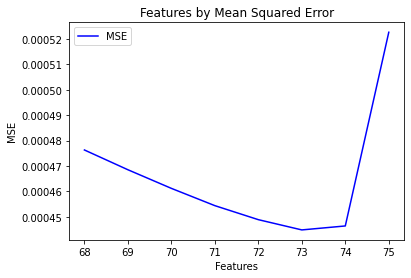

Dropping  Flow IAT Min
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 1ms/sample - loss: 0.6555 - accuracy: 0.5088
Epoch 2/10
57/57 [==============================] - 0s 124us/sample - loss: 0.5872 - accuracy: 0.5614
Epoch 3/10
57/57 [==============================] - 0s 142us/sample - loss: 0.5283 - accuracy: 0.8070
Epoch 4/10
57/57 [==============================] - 0s 86us/sample - loss: 0.4777 - accuracy: 0.8947
Epoch 5/10
57/57 [==============================] - 0s 107us/sample - loss: 0.4350 - accuracy: 0.9298
Epoch 6/10
57/57 [==============================] - 0s 102us/sample - loss: 0.3960 - accuracy: 0.9298
Epoch 7/10
57/57 [==============================] - 0s 86us/sample - loss: 0.3557 - accuracy: 0.9474
Epoch 8/10
57/57 [==============================] - 0s 87us/sample - loss: 0.3219 - accuracy: 0.9825
Epoch 9/10
57/57 [==============================] - 0s 152us/sample - loss: 0.2893 - accuracy: 0.9825
Epoch 10/10
15/15 [=========================

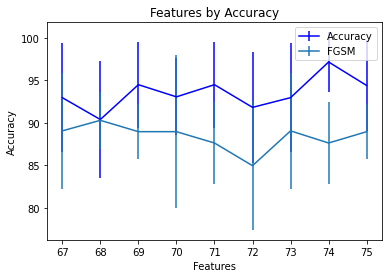

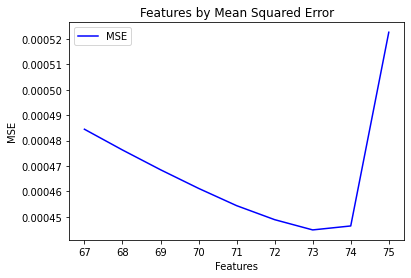

Dropping  Bwd Packet Length Std
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.7056 - accuracy: 0.5088
Epoch 2/10
57/57 [==============================] - 0s 137us/sample - loss: 0.6398 - accuracy: 0.8596
Epoch 3/10
57/57 [==============================] - 0s 99us/sample - loss: 0.5818 - accuracy: 0.9123
Epoch 4/10
57/57 [==============================] - 0s 94us/sample - loss: 0.5377 - accuracy: 0.9298
Epoch 5/10
57/57 [==============================] - 0s 139us/sample - loss: 0.4961 - accuracy: 0.9298
Epoch 6/10
57/57 [==============================] - 0s 105us/sample - loss: 0.4584 - accuracy: 0.9298
Epoch 7/10
57/57 [==============================] - 0s 82us/sample - loss: 0.4234 - accuracy: 0.9298
Epoch 8/10
57/57 [==============================] - 0s 87us/sample - loss: 0.3883 - accuracy: 0.9298
Epoch 9/10
57/57 [==============================] - 0s 78us/sample - loss: 0.3593 - accuracy: 0.9298
Epoch 10/10
15/15 [==================

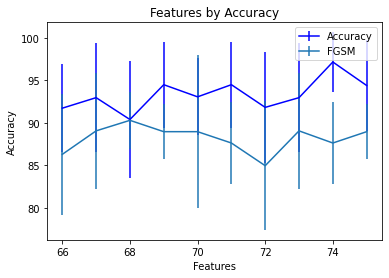

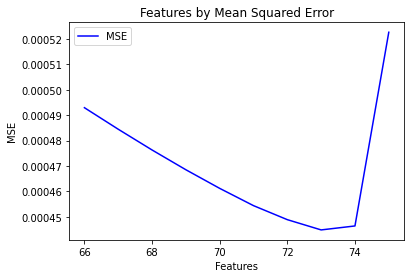

Dropping  Fwd IAT Min
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.6701 - accuracy: 0.6491
Epoch 2/10
57/57 [==============================] - 0s 124us/sample - loss: 0.5933 - accuracy: 0.8596
Epoch 3/10
57/57 [==============================] - 0s 107us/sample - loss: 0.5272 - accuracy: 0.9123
Epoch 4/10
57/57 [==============================] - 0s 102us/sample - loss: 0.4741 - accuracy: 0.9474
Epoch 5/10
57/57 [==============================] - 0s 104us/sample - loss: 0.4340 - accuracy: 0.9474
Epoch 6/10
57/57 [==============================] - 0s 112us/sample - loss: 0.3920 - accuracy: 0.9649
Epoch 7/10
57/57 [==============================] - 0s 133us/sample - loss: 0.3544 - accuracy: 0.9649
Epoch 8/10
57/57 [==============================] - 0s 74us/sample - loss: 0.3173 - accuracy: 0.9649
Epoch 9/10
57/57 [==============================] - 0s 98us/sample - loss: 0.2863 - accuracy: 0.9649
Epoch 10/10
15/15 [=========================

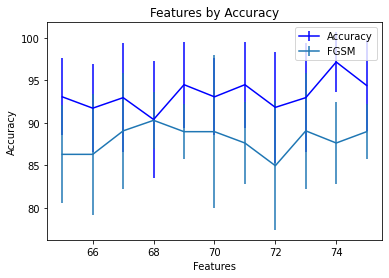

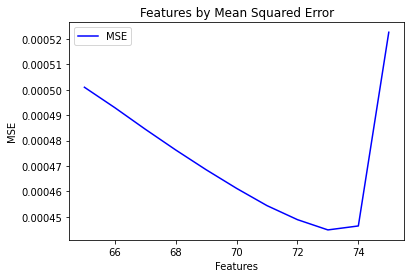

Dropping  Bwd Packets/s
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 1ms/sample - loss: 0.6987 - accuracy: 0.4737
Epoch 2/10
57/57 [==============================] - 0s 119us/sample - loss: 0.6091 - accuracy: 0.7193
Epoch 3/10
57/57 [==============================] - 0s 93us/sample - loss: 0.5464 - accuracy: 0.7895
Epoch 4/10
57/57 [==============================] - 0s 92us/sample - loss: 0.4984 - accuracy: 0.9298
Epoch 5/10
57/57 [==============================] - 0s 78us/sample - loss: 0.4579 - accuracy: 0.9123
Epoch 6/10
57/57 [==============================] - 0s 87us/sample - loss: 0.4232 - accuracy: 0.8947
Epoch 7/10
57/57 [==============================] - 0s 115us/sample - loss: 0.3929 - accuracy: 0.9123
Epoch 8/10
57/57 [==============================] - 0s 124us/sample - loss: 0.3639 - accuracy: 0.9649
Epoch 9/10
57/57 [==============================] - 0s 116us/sample - loss: 0.3341 - accuracy: 0.9649
Epoch 10/10
15/15 [=========================

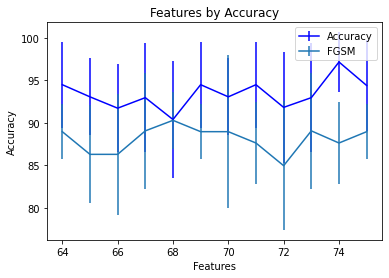

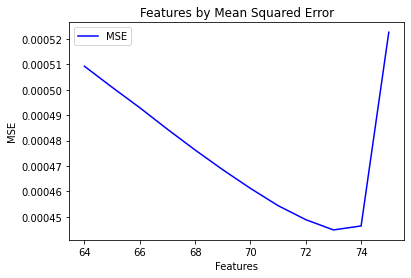

Dropping  Active Std
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.6699 - accuracy: 0.6667
Epoch 2/10
57/57 [==============================] - 0s 91us/sample - loss: 0.5860 - accuracy: 0.8596
Epoch 3/10
57/57 [==============================] - 0s 84us/sample - loss: 0.5235 - accuracy: 0.8772
Epoch 4/10
57/57 [==============================] - 0s 84us/sample - loss: 0.4718 - accuracy: 0.8947
Epoch 5/10
57/57 [==============================] - 0s 81us/sample - loss: 0.4276 - accuracy: 0.9123
Epoch 6/10
57/57 [==============================] - 0s 102us/sample - loss: 0.3882 - accuracy: 0.9298
Epoch 7/10
57/57 [==============================] - 0s 94us/sample - loss: 0.3505 - accuracy: 0.9474
Epoch 8/10
57/57 [==============================] - 0s 118us/sample - loss: 0.3147 - accuracy: 0.9474
Epoch 9/10
57/57 [==============================] - 0s 213us/sample - loss: 0.2810 - accuracy: 0.9825
Epoch 10/10
15/15 [=============================

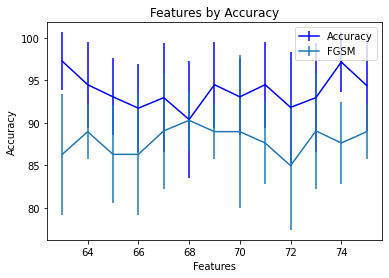

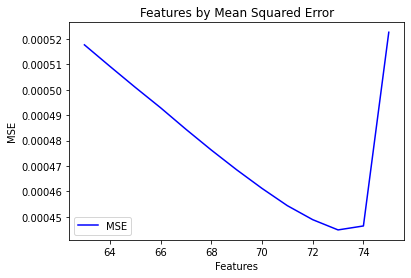

Dropping Init_Win_bytes_forward
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.6980 - accuracy: 0.5263
Epoch 2/10
57/57 [==============================] - 0s 98us/sample - loss: 0.6101 - accuracy: 0.7544
Epoch 3/10
57/57 [==============================] - 0s 96us/sample - loss: 0.5424 - accuracy: 0.8947
Epoch 4/10
57/57 [==============================] - 0s 85us/sample - loss: 0.4905 - accuracy: 0.8947
Epoch 5/10
57/57 [==============================] - 0s 92us/sample - loss: 0.4449 - accuracy: 0.8947
Epoch 6/10
57/57 [==============================] - 0s 81us/sample - loss: 0.4042 - accuracy: 0.9123
Epoch 7/10
57/57 [==============================] - 0s 125us/sample - loss: 0.3682 - accuracy: 0.9123
Epoch 8/10
57/57 [==============================] - 0s 93us/sample - loss: 0.3368 - accuracy: 0.9123
Epoch 9/10
57/57 [==============================] - 0s 84us/sample - loss: 0.3095 - accuracy: 0.9123
Epoch 10/10
15/15 [====================

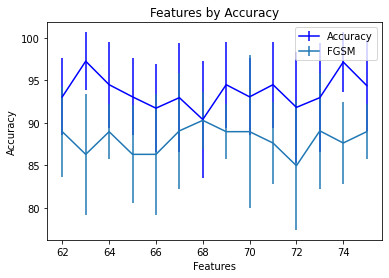

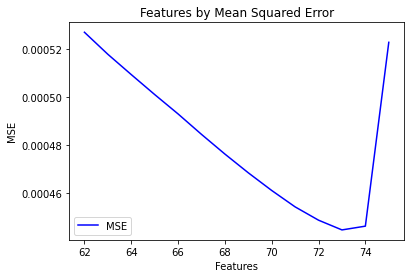

Dropping  Fwd IAT Mean
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.7666 - accuracy: 0.4912
Epoch 2/10
57/57 [==============================] - 0s 138us/sample - loss: 0.6513 - accuracy: 0.6667
Epoch 3/10
57/57 [==============================] - 0s 106us/sample - loss: 0.5649 - accuracy: 0.9474
Epoch 4/10
57/57 [==============================] - 0s 119us/sample - loss: 0.5088 - accuracy: 0.9474
Epoch 5/10
57/57 [==============================] - 0s 81us/sample - loss: 0.4659 - accuracy: 0.9298
Epoch 6/10
57/57 [==============================] - 0s 89us/sample - loss: 0.4289 - accuracy: 0.9474
Epoch 7/10
57/57 [==============================] - 0s 90us/sample - loss: 0.3946 - accuracy: 0.9649
Epoch 8/10
57/57 [==============================] - 0s 87us/sample - loss: 0.3616 - accuracy: 0.9825
Epoch 9/10
57/57 [==============================] - 0s 135us/sample - loss: 0.3296 - accuracy: 0.9649
Epoch 10/10
15/15 [==========================

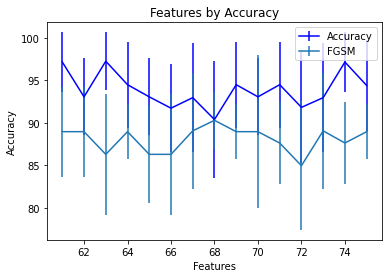

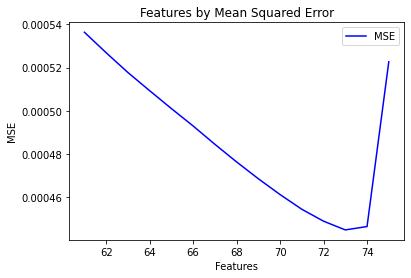

Dropping  Flow IAT Mean
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.7852 - accuracy: 0.4912
Epoch 2/10
57/57 [==============================] - 0s 82us/sample - loss: 0.6868 - accuracy: 0.4912
Epoch 3/10
57/57 [==============================] - 0s 79us/sample - loss: 0.6119 - accuracy: 0.8596
Epoch 4/10
57/57 [==============================] - 0s 78us/sample - loss: 0.5519 - accuracy: 0.9474
Epoch 5/10
57/57 [==============================] - 0s 74us/sample - loss: 0.5002 - accuracy: 0.9474
Epoch 6/10
57/57 [==============================] - 0s 79us/sample - loss: 0.4604 - accuracy: 0.9649
Epoch 7/10
57/57 [==============================] - 0s 88us/sample - loss: 0.4230 - accuracy: 0.9825
Epoch 8/10
57/57 [==============================] - 0s 87us/sample - loss: 0.3902 - accuracy: 0.9825
Epoch 9/10
57/57 [==============================] - 0s 101us/sample - loss: 0.3594 - accuracy: 0.9825
Epoch 10/10
15/15 [============================

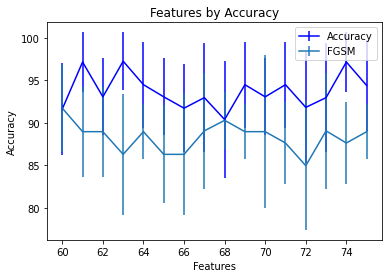

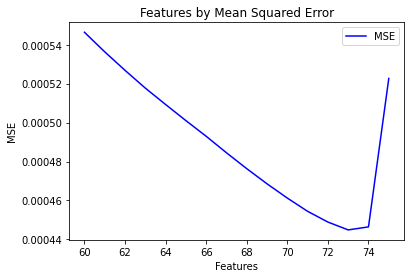

Dropping  Packet Length Variance
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 1ms/sample - loss: 0.6374 - accuracy: 0.7719
Epoch 2/10
57/57 [==============================] - 0s 111us/sample - loss: 0.5733 - accuracy: 0.7895
Epoch 3/10
57/57 [==============================] - 0s 89us/sample - loss: 0.5216 - accuracy: 0.8246
Epoch 4/10
57/57 [==============================] - 0s 85us/sample - loss: 0.4758 - accuracy: 0.8421
Epoch 5/10
57/57 [==============================] - 0s 73us/sample - loss: 0.4394 - accuracy: 0.8596
Epoch 6/10
57/57 [==============================] - 0s 92us/sample - loss: 0.4057 - accuracy: 0.8596
Epoch 7/10
57/57 [==============================] - 0s 104us/sample - loss: 0.3767 - accuracy: 0.9123
Epoch 8/10
57/57 [==============================] - 0s 78us/sample - loss: 0.3461 - accuracy: 0.9298
Epoch 9/10
57/57 [==============================] - 0s 120us/sample - loss: 0.3175 - accuracy: 0.9474
Epoch 10/10
15/15 [=================

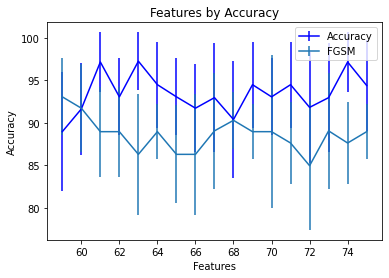

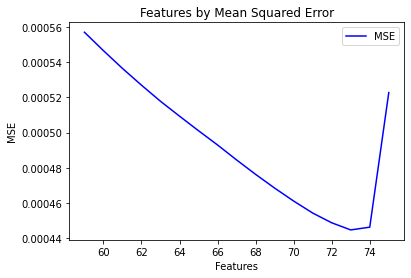

Dropping  Active Min
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.6579 - accuracy: 0.7368
Epoch 2/10
57/57 [==============================] - 0s 114us/sample - loss: 0.5909 - accuracy: 0.8772
Epoch 3/10
57/57 [==============================] - 0s 91us/sample - loss: 0.5390 - accuracy: 0.8947
Epoch 4/10
57/57 [==============================] - 0s 115us/sample - loss: 0.4889 - accuracy: 0.9123
Epoch 5/10
57/57 [==============================] - 0s 100us/sample - loss: 0.4504 - accuracy: 0.9123
Epoch 6/10
57/57 [==============================] - 0s 148us/sample - loss: 0.4157 - accuracy: 0.9123
Epoch 7/10
57/57 [==============================] - 0s 91us/sample - loss: 0.3858 - accuracy: 0.9123
Epoch 8/10
57/57 [==============================] - 0s 93us/sample - loss: 0.3563 - accuracy: 0.9298
Epoch 9/10
57/57 [==============================] - 0s 79us/sample - loss: 0.3269 - accuracy: 0.9298
Epoch 10/10
15/15 [============================

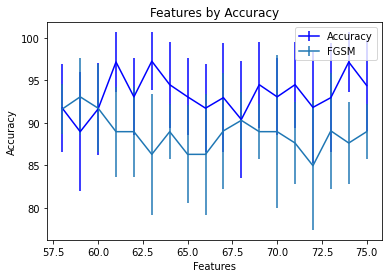

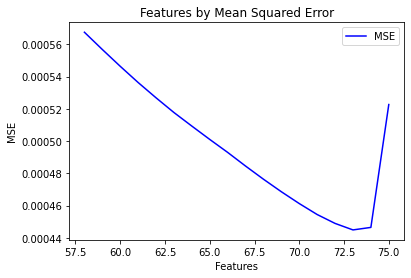

Dropping  URG Flag Count
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 1ms/sample - loss: 0.6871 - accuracy: 0.6316
Epoch 2/10
57/57 [==============================] - 0s 108us/sample - loss: 0.6228 - accuracy: 0.8421
Epoch 3/10
57/57 [==============================] - 0s 79us/sample - loss: 0.5755 - accuracy: 0.8596
Epoch 4/10
57/57 [==============================] - 0s 100us/sample - loss: 0.5380 - accuracy: 0.9298
Epoch 5/10
57/57 [==============================] - 0s 93us/sample - loss: 0.5045 - accuracy: 0.9298
Epoch 6/10
57/57 [==============================] - 0s 97us/sample - loss: 0.4764 - accuracy: 0.9474
Epoch 7/10
57/57 [==============================] - 0s 99us/sample - loss: 0.4473 - accuracy: 0.9474
Epoch 8/10
57/57 [==============================] - 0s 108us/sample - loss: 0.4180 - accuracy: 0.9474
Epoch 9/10
57/57 [==============================] - 0s 72us/sample - loss: 0.3895 - accuracy: 0.9474
Epoch 10/10
15/15 [=========================

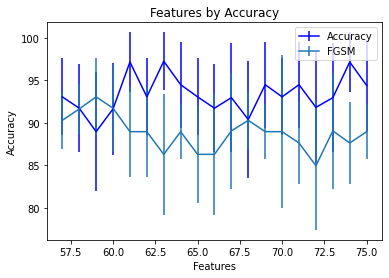

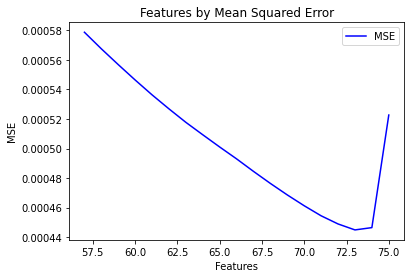

Dropping  Average Packet Size
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.7039 - accuracy: 0.4386
Epoch 2/10
57/57 [==============================] - 0s 88us/sample - loss: 0.6275 - accuracy: 0.6316
Epoch 3/10
57/57 [==============================] - 0s 107us/sample - loss: 0.5659 - accuracy: 0.8246
Epoch 4/10
57/57 [==============================] - 0s 115us/sample - loss: 0.5174 - accuracy: 0.9123
Epoch 5/10
57/57 [==============================] - 0s 110us/sample - loss: 0.4768 - accuracy: 0.9123
Epoch 6/10
57/57 [==============================] - 0s 133us/sample - loss: 0.4372 - accuracy: 0.9123
Epoch 7/10
57/57 [==============================] - 0s 86us/sample - loss: 0.4006 - accuracy: 0.9298
Epoch 8/10
57/57 [==============================] - 0s 118us/sample - loss: 0.3671 - accuracy: 0.9474
Epoch 9/10
57/57 [==============================] - 0s 99us/sample - loss: 0.3340 - accuracy: 0.9474
Epoch 10/10
15/15 [==================

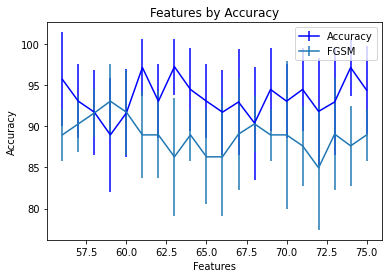

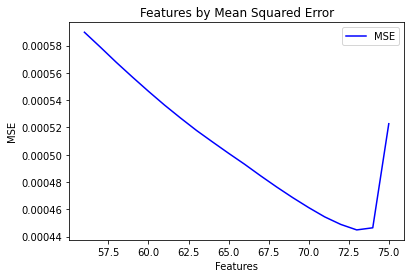

Dropping  Bwd IAT Mean
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.7360 - accuracy: 0.3860
Epoch 2/10
57/57 [==============================] - 0s 112us/sample - loss: 0.6418 - accuracy: 0.6316
Epoch 3/10
57/57 [==============================] - 0s 66us/sample - loss: 0.5771 - accuracy: 0.7895
Epoch 4/10
57/57 [==============================] - 0s 192us/sample - loss: 0.5232 - accuracy: 0.8421
Epoch 5/10
57/57 [==============================] - 0s 121us/sample - loss: 0.4733 - accuracy: 0.8772
Epoch 6/10
57/57 [==============================] - 0s 140us/sample - loss: 0.4313 - accuracy: 0.9123
Epoch 7/10
57/57 [==============================] - 0s 197us/sample - loss: 0.3919 - accuracy: 0.9649
Epoch 8/10
57/57 [==============================] - 0s 134us/sample - loss: 0.3564 - accuracy: 0.9649
Epoch 9/10
57/57 [==============================] - 0s 105us/sample - loss: 0.3243 - accuracy: 0.9474
Epoch 10/10
15/15 [=======================

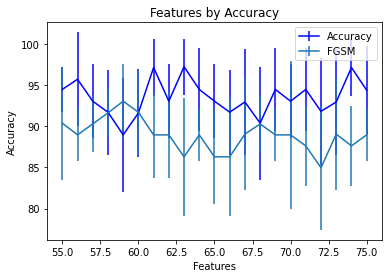

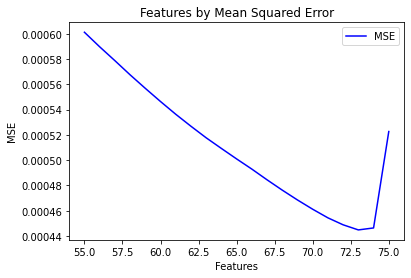

Dropping Active Mean
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 1ms/sample - loss: 0.5987 - accuracy: 0.7544
Epoch 2/10
57/57 [==============================] - 0s 96us/sample - loss: 0.5349 - accuracy: 0.7544
Epoch 3/10
57/57 [==============================] - 0s 61us/sample - loss: 0.4845 - accuracy: 0.7544
Epoch 4/10
57/57 [==============================] - 0s 88us/sample - loss: 0.4492 - accuracy: 0.7544
Epoch 5/10
57/57 [==============================] - 0s 106us/sample - loss: 0.4184 - accuracy: 0.8421
Epoch 6/10
57/57 [==============================] - 0s 106us/sample - loss: 0.3892 - accuracy: 0.8947
Epoch 7/10
57/57 [==============================] - 0s 103us/sample - loss: 0.3606 - accuracy: 0.9123
Epoch 8/10
57/57 [==============================] - 0s 75us/sample - loss: 0.3301 - accuracy: 0.9123
Epoch 9/10
57/57 [==============================] - 0s 86us/sample - loss: 0.3031 - accuracy: 0.9123
Epoch 10/10
15/15 [=============================

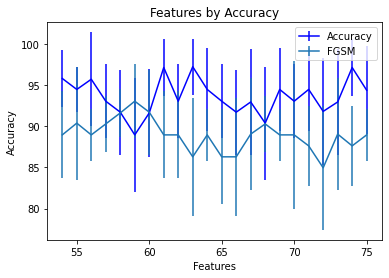

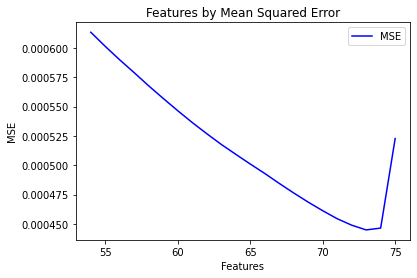

Dropping  Subflow Fwd Bytes
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.6848 - accuracy: 0.5965
Epoch 2/10
57/57 [==============================] - 0s 129us/sample - loss: 0.5942 - accuracy: 0.9298
Epoch 3/10
57/57 [==============================] - 0s 119us/sample - loss: 0.5243 - accuracy: 0.9298
Epoch 4/10
57/57 [==============================] - 0s 124us/sample - loss: 0.4670 - accuracy: 0.9123
Epoch 5/10
57/57 [==============================] - 0s 107us/sample - loss: 0.4224 - accuracy: 0.9123
Epoch 6/10
57/57 [==============================] - 0s 90us/sample - loss: 0.3868 - accuracy: 0.9123
Epoch 7/10
57/57 [==============================] - 0s 90us/sample - loss: 0.3549 - accuracy: 0.9123
Epoch 8/10
57/57 [==============================] - 0s 89us/sample - loss: 0.3281 - accuracy: 0.9298
Epoch 9/10
57/57 [==============================] - 0s 85us/sample - loss: 0.3011 - accuracy: 0.9474
Epoch 10/10
15/15 [=====================

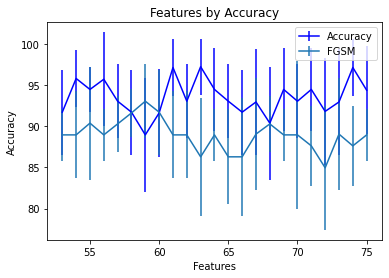

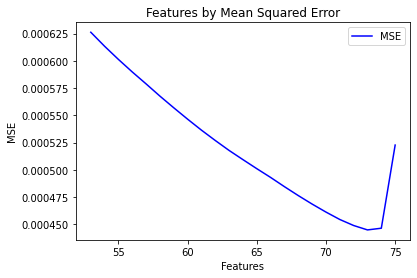

Dropping  Packet Length Mean
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.6920 - accuracy: 0.5614
Epoch 2/10
57/57 [==============================] - 0s 95us/sample - loss: 0.5952 - accuracy: 0.8421
Epoch 3/10
57/57 [==============================] - 0s 83us/sample - loss: 0.5255 - accuracy: 0.9474
Epoch 4/10
57/57 [==============================] - 0s 93us/sample - loss: 0.4644 - accuracy: 0.9649
Epoch 5/10
57/57 [==============================] - 0s 91us/sample - loss: 0.4147 - accuracy: 0.9649
Epoch 6/10
57/57 [==============================] - 0s 88us/sample - loss: 0.3703 - accuracy: 0.9649
Epoch 7/10
57/57 [==============================] - 0s 84us/sample - loss: 0.3316 - accuracy: 0.9649
Epoch 8/10
57/57 [==============================] - 0s 91us/sample - loss: 0.2977 - accuracy: 0.9649
Epoch 9/10
57/57 [==============================] - 0s 89us/sample - loss: 0.2655 - accuracy: 0.9649
Epoch 10/10
15/15 [========================

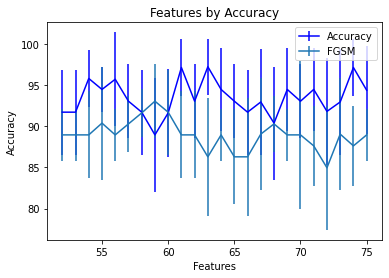

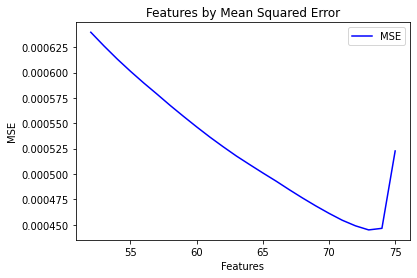

Dropping Subflow Fwd Packets
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 1ms/sample - loss: 0.6844 - accuracy: 0.6140
Epoch 2/10
57/57 [==============================] - 0s 134us/sample - loss: 0.6207 - accuracy: 0.7544
Epoch 3/10
57/57 [==============================] - 0s 124us/sample - loss: 0.5641 - accuracy: 0.8246
Epoch 4/10
57/57 [==============================] - 0s 92us/sample - loss: 0.5164 - accuracy: 0.8421
Epoch 5/10
57/57 [==============================] - 0s 86us/sample - loss: 0.4731 - accuracy: 0.8947
Epoch 6/10
57/57 [==============================] - 0s 83us/sample - loss: 0.4353 - accuracy: 0.9123
Epoch 7/10
57/57 [==============================] - 0s 78us/sample - loss: 0.4041 - accuracy: 0.9123
Epoch 8/10
57/57 [==============================] - 0s 77us/sample - loss: 0.3731 - accuracy: 0.9123
Epoch 9/10
57/57 [==============================] - 0s 85us/sample - loss: 0.3429 - accuracy: 0.9123
Epoch 10/10
15/15 [======================

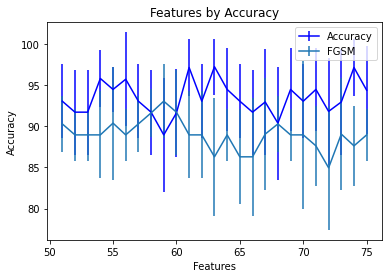

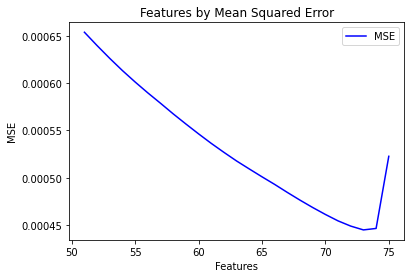

Dropping  Active Max
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.6438 - accuracy: 0.5263
Epoch 2/10
57/57 [==============================] - 0s 99us/sample - loss: 0.5982 - accuracy: 0.5439
Epoch 3/10
57/57 [==============================] - 0s 93us/sample - loss: 0.5587 - accuracy: 0.5439
Epoch 4/10
57/57 [==============================] - 0s 90us/sample - loss: 0.5258 - accuracy: 0.6842
Epoch 5/10
57/57 [==============================] - 0s 87us/sample - loss: 0.4936 - accuracy: 0.8596
Epoch 6/10
57/57 [==============================] - 0s 124us/sample - loss: 0.4653 - accuracy: 0.8596
Epoch 7/10
57/57 [==============================] - 0s 120us/sample - loss: 0.4391 - accuracy: 0.8772
Epoch 8/10
57/57 [==============================] - 0s 119us/sample - loss: 0.4150 - accuracy: 0.8947
Epoch 9/10
57/57 [==============================] - 0s 122us/sample - loss: 0.3901 - accuracy: 0.9123
Epoch 10/10
15/15 [============================

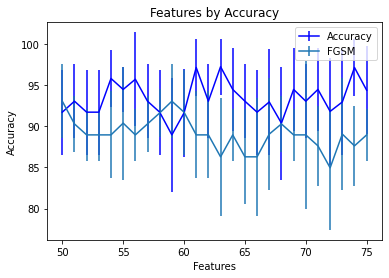

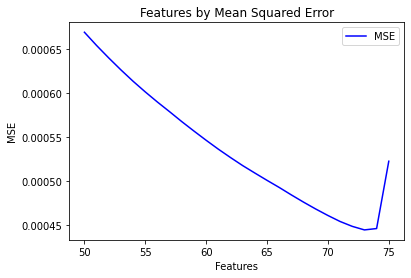

Dropping  Subflow Bwd Packets
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.6694 - accuracy: 0.5088
Epoch 2/10
57/57 [==============================] - 0s 98us/sample - loss: 0.6106 - accuracy: 0.5789
Epoch 3/10
57/57 [==============================] - 0s 134us/sample - loss: 0.5628 - accuracy: 0.7368
Epoch 4/10
57/57 [==============================] - 0s 94us/sample - loss: 0.5243 - accuracy: 0.7895
Epoch 5/10
57/57 [==============================] - 0s 60us/sample - loss: 0.4875 - accuracy: 0.8596
Epoch 6/10
57/57 [==============================] - 0s 74us/sample - loss: 0.4522 - accuracy: 0.9123
Epoch 7/10
57/57 [==============================] - 0s 123us/sample - loss: 0.4195 - accuracy: 0.9123
Epoch 8/10
57/57 [==============================] - 0s 128us/sample - loss: 0.3883 - accuracy: 0.9298
Epoch 9/10
57/57 [==============================] - 0s 102us/sample - loss: 0.3589 - accuracy: 0.9298
Epoch 10/10
15/15 [===================

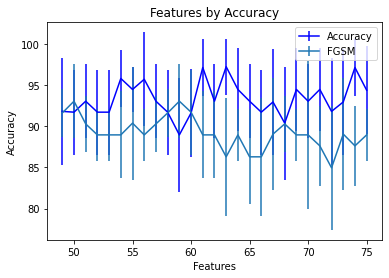

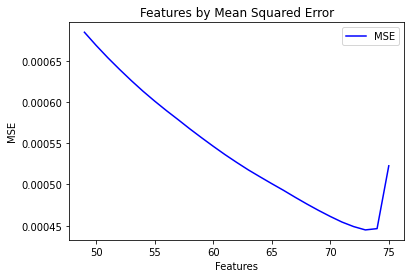

Dropping  Fwd Header Length
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 1ms/sample - loss: 0.6814 - accuracy: 0.6842
Epoch 2/10
57/57 [==============================] - 0s 139us/sample - loss: 0.6062 - accuracy: 0.8421
Epoch 3/10
57/57 [==============================] - 0s 98us/sample - loss: 0.5548 - accuracy: 0.9123
Epoch 4/10
57/57 [==============================] - 0s 82us/sample - loss: 0.5141 - accuracy: 0.9298
Epoch 5/10
57/57 [==============================] - 0s 145us/sample - loss: 0.4743 - accuracy: 0.9298
Epoch 6/10
57/57 [==============================] - 0s 106us/sample - loss: 0.4427 - accuracy: 0.9298
Epoch 7/10
57/57 [==============================] - 0s 91us/sample - loss: 0.4124 - accuracy: 0.9474
Epoch 8/10
57/57 [==============================] - 0s 132us/sample - loss: 0.3843 - accuracy: 0.9474
Epoch 9/10
57/57 [==============================] - 0s 98us/sample - loss: 0.3580 - accuracy: 0.9474
Epoch 10/10
15/15 [=====================

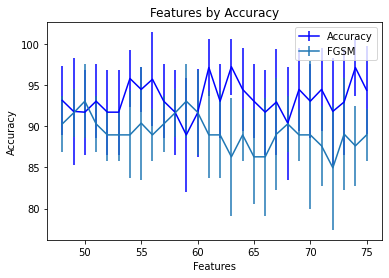

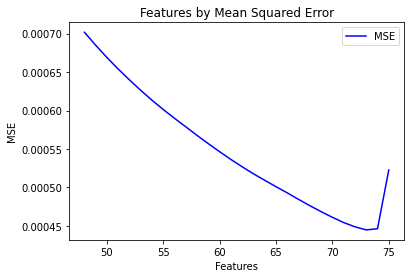

Dropping  Fwd Header Length.1
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.6634 - accuracy: 0.6842
Epoch 2/10
57/57 [==============================] - 0s 107us/sample - loss: 0.6040 - accuracy: 0.7719
Epoch 3/10
57/57 [==============================] - 0s 90us/sample - loss: 0.5538 - accuracy: 0.8421
Epoch 4/10
57/57 [==============================] - 0s 89us/sample - loss: 0.5086 - accuracy: 0.8772
Epoch 5/10
57/57 [==============================] - 0s 79us/sample - loss: 0.4694 - accuracy: 0.8947
Epoch 6/10
57/57 [==============================] - 0s 87us/sample - loss: 0.4358 - accuracy: 0.9123
Epoch 7/10
57/57 [==============================] - 0s 95us/sample - loss: 0.4002 - accuracy: 0.9123
Epoch 8/10
57/57 [==============================] - 0s 103us/sample - loss: 0.3680 - accuracy: 0.9298
Epoch 9/10
57/57 [==============================] - 0s 85us/sample - loss: 0.3363 - accuracy: 0.9474
Epoch 10/10
15/15 [=====================

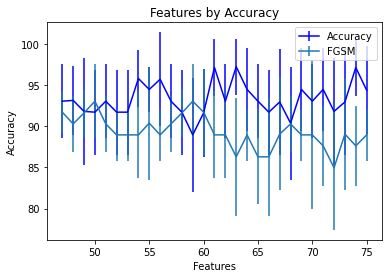

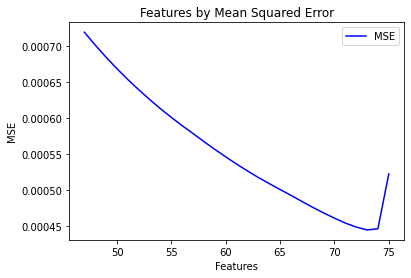

Dropping  Bwd Header Length
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.7489 - accuracy: 0.4211
Epoch 2/10
57/57 [==============================] - 0s 110us/sample - loss: 0.6354 - accuracy: 0.7193
Epoch 3/10
57/57 [==============================] - 0s 95us/sample - loss: 0.5585 - accuracy: 0.8246
Epoch 4/10
57/57 [==============================] - 0s 91us/sample - loss: 0.5025 - accuracy: 0.8596
Epoch 5/10
57/57 [==============================] - 0s 95us/sample - loss: 0.4599 - accuracy: 0.8947
Epoch 6/10
57/57 [==============================] - 0s 127us/sample - loss: 0.4264 - accuracy: 0.8947
Epoch 7/10
57/57 [==============================] - 0s 137us/sample - loss: 0.3924 - accuracy: 0.8947
Epoch 8/10
57/57 [==============================] - 0s 110us/sample - loss: 0.3615 - accuracy: 0.8947
Epoch 9/10
57/57 [==============================] - 0s 64us/sample - loss: 0.3339 - accuracy: 0.8947
Epoch 10/10
15/15 [=====================

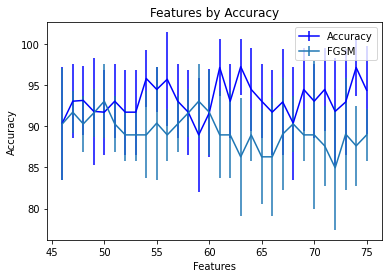

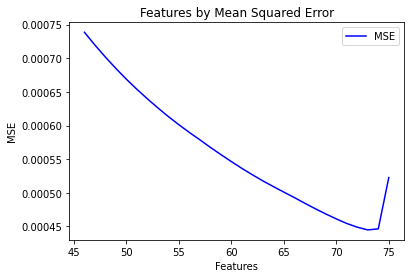

Dropping  act_data_pkt_fwd
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 1ms/sample - loss: 0.6250 - accuracy: 0.4561
Epoch 2/10
57/57 [==============================] - 0s 99us/sample - loss: 0.5585 - accuracy: 0.5789
Epoch 3/10
57/57 [==============================] - 0s 135us/sample - loss: 0.5098 - accuracy: 0.7719
Epoch 4/10
57/57 [==============================] - 0s 91us/sample - loss: 0.4705 - accuracy: 0.8947
Epoch 5/10
57/57 [==============================] - 0s 121us/sample - loss: 0.4364 - accuracy: 0.8947
Epoch 6/10
57/57 [==============================] - 0s 106us/sample - loss: 0.3993 - accuracy: 0.9123
Epoch 7/10
57/57 [==============================] - 0s 110us/sample - loss: 0.3675 - accuracy: 0.9123
Epoch 8/10
57/57 [==============================] - 0s 98us/sample - loss: 0.3349 - accuracy: 0.9825
Epoch 9/10
57/57 [==============================] - 0s 105us/sample - loss: 0.3054 - accuracy: 0.9825
Epoch 10/10
15/15 [=====================

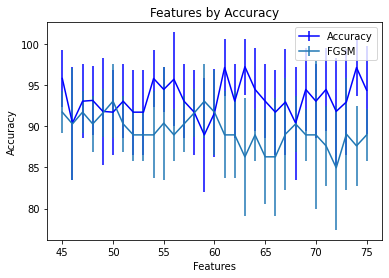

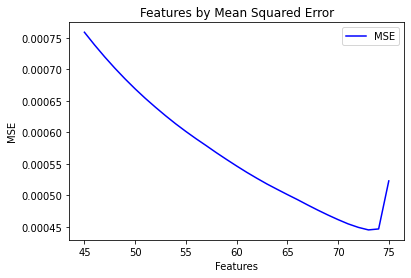

Dropping  Flow IAT Std
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.6900 - accuracy: 0.5088
Epoch 2/10
57/57 [==============================] - 0s 84us/sample - loss: 0.6111 - accuracy: 0.9474
Epoch 3/10
57/57 [==============================] - 0s 109us/sample - loss: 0.5495 - accuracy: 0.9123
Epoch 4/10
57/57 [==============================] - 0s 100us/sample - loss: 0.5007 - accuracy: 0.9123
Epoch 5/10
57/57 [==============================] - 0s 99us/sample - loss: 0.4559 - accuracy: 0.9123
Epoch 6/10
57/57 [==============================] - 0s 109us/sample - loss: 0.4201 - accuracy: 0.9123
Epoch 7/10
57/57 [==============================] - 0s 90us/sample - loss: 0.3897 - accuracy: 0.9123
Epoch 8/10
57/57 [==============================] - 0s 120us/sample - loss: 0.3570 - accuracy: 0.9123
Epoch 9/10
57/57 [==============================] - 0s 114us/sample - loss: 0.3281 - accuracy: 0.9123
Epoch 10/10
15/15 [=========================

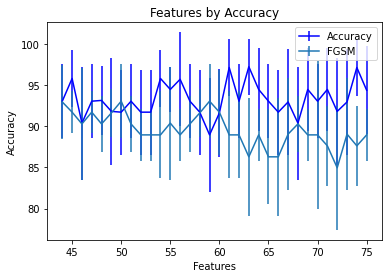

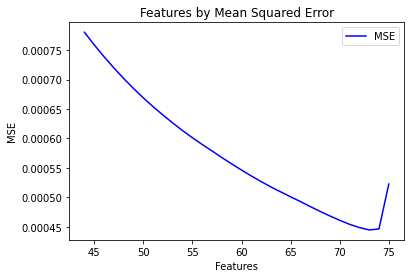

Dropping  Bwd Packet Length Min
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.6729 - accuracy: 0.5263
Epoch 2/10
57/57 [==============================] - 0s 135us/sample - loss: 0.6088 - accuracy: 0.8246
Epoch 3/10
57/57 [==============================] - 0s 117us/sample - loss: 0.5567 - accuracy: 0.8772
Epoch 4/10
57/57 [==============================] - 0s 97us/sample - loss: 0.5135 - accuracy: 0.8772
Epoch 5/10
57/57 [==============================] - 0s 91us/sample - loss: 0.4710 - accuracy: 0.9123
Epoch 6/10
57/57 [==============================] - 0s 97us/sample - loss: 0.4374 - accuracy: 0.9474
Epoch 7/10
57/57 [==============================] - 0s 96us/sample - loss: 0.4040 - accuracy: 0.9474
Epoch 8/10
57/57 [==============================] - 0s 131us/sample - loss: 0.3734 - accuracy: 0.9474
Epoch 9/10
57/57 [==============================] - 0s 100us/sample - loss: 0.3426 - accuracy: 0.9649
Epoch 10/10
15/15 [=================

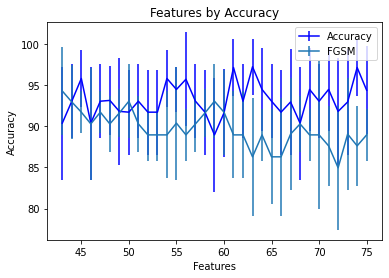

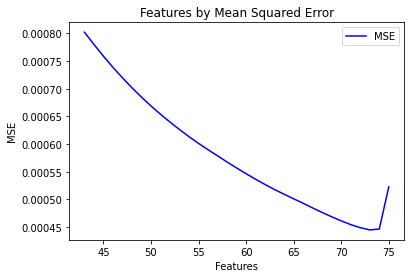

Dropping  Fwd Packet Length Mean
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.6909 - accuracy: 0.4737
Epoch 2/10
57/57 [==============================] - 0s 95us/sample - loss: 0.6359 - accuracy: 0.6491
Epoch 3/10
57/57 [==============================] - 0s 92us/sample - loss: 0.5861 - accuracy: 0.8772
Epoch 4/10
57/57 [==============================] - 0s 91us/sample - loss: 0.5452 - accuracy: 0.8947
Epoch 5/10
57/57 [==============================] - 0s 113us/sample - loss: 0.5071 - accuracy: 0.9298
Epoch 6/10
57/57 [==============================] - 0s 86us/sample - loss: 0.4703 - accuracy: 0.9298
Epoch 7/10
57/57 [==============================] - 0s 96us/sample - loss: 0.4394 - accuracy: 0.9474
Epoch 8/10
57/57 [==============================] - 0s 101us/sample - loss: 0.4116 - accuracy: 0.9474
Epoch 9/10
57/57 [==============================] - 0s 117us/sample - loss: 0.3836 - accuracy: 0.9474
Epoch 10/10
15/15 [=================

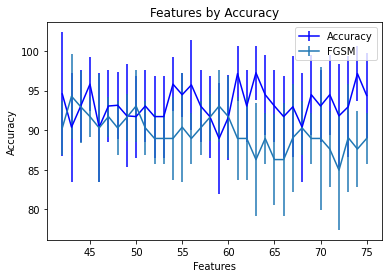

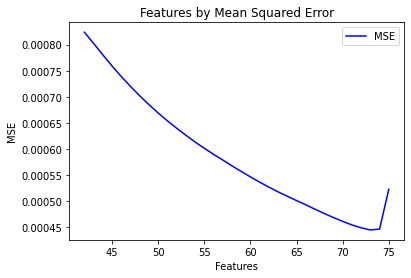

Dropping  Idle Std
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 1ms/sample - loss: 0.6743 - accuracy: 0.4912
Epoch 2/10
57/57 [==============================] - 0s 87us/sample - loss: 0.6084 - accuracy: 0.5263
Epoch 3/10
57/57 [==============================] - 0s 94us/sample - loss: 0.5636 - accuracy: 0.6316
Epoch 4/10
57/57 [==============================] - 0s 92us/sample - loss: 0.5218 - accuracy: 0.7719
Epoch 5/10
57/57 [==============================] - 0s 87us/sample - loss: 0.4899 - accuracy: 0.8070
Epoch 6/10
57/57 [==============================] - 0s 121us/sample - loss: 0.4576 - accuracy: 0.8772
Epoch 7/10
57/57 [==============================] - 0s 228us/sample - loss: 0.4281 - accuracy: 0.9123
Epoch 8/10
57/57 [==============================] - 0s 83us/sample - loss: 0.3996 - accuracy: 0.9123
Epoch 9/10
57/57 [==============================] - 0s 86us/sample - loss: 0.3709 - accuracy: 0.9123
Epoch 10/10
15/15 [==============================] 

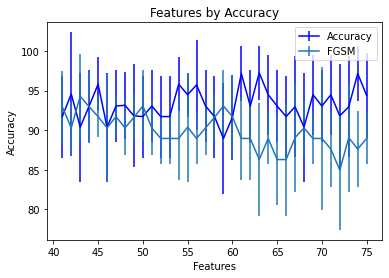

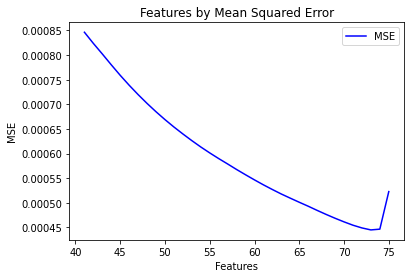

Dropping  Min Packet Length
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.6657 - accuracy: 0.4561
Epoch 2/10
57/57 [==============================] - 0s 111us/sample - loss: 0.6064 - accuracy: 0.5263
Epoch 3/10
57/57 [==============================] - 0s 81us/sample - loss: 0.5614 - accuracy: 0.6842
Epoch 4/10
57/57 [==============================] - 0s 101us/sample - loss: 0.5217 - accuracy: 0.7895
Epoch 5/10
57/57 [==============================] - 0s 85us/sample - loss: 0.4911 - accuracy: 0.8596
Epoch 6/10
57/57 [==============================] - 0s 94us/sample - loss: 0.4604 - accuracy: 0.8596
Epoch 7/10
57/57 [==============================] - 0s 91us/sample - loss: 0.4342 - accuracy: 0.8947
Epoch 8/10
57/57 [==============================] - 0s 91us/sample - loss: 0.4070 - accuracy: 0.9123
Epoch 9/10
57/57 [==============================] - 0s 128us/sample - loss: 0.3818 - accuracy: 0.8947
Epoch 10/10
15/15 [======================

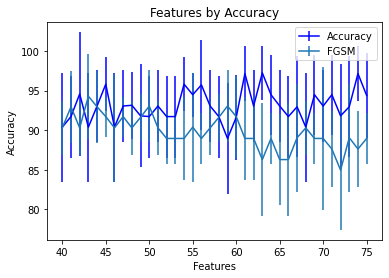

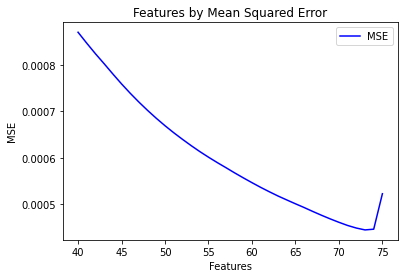

Dropping  Packet Length Std
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 1ms/sample - loss: 0.6756 - accuracy: 0.6667
Epoch 2/10
57/57 [==============================] - 0s 127us/sample - loss: 0.6071 - accuracy: 0.9123
Epoch 3/10
57/57 [==============================] - 0s 105us/sample - loss: 0.5561 - accuracy: 0.9123
Epoch 4/10
57/57 [==============================] - 0s 68us/sample - loss: 0.5112 - accuracy: 0.9298
Epoch 5/10
57/57 [==============================] - 0s 84us/sample - loss: 0.4792 - accuracy: 0.9298
Epoch 6/10
57/57 [==============================] - 0s 115us/sample - loss: 0.4448 - accuracy: 0.9298
Epoch 7/10
57/57 [==============================] - 0s 62us/sample - loss: 0.4155 - accuracy: 0.9298
Epoch 8/10
57/57 [==============================] - 0s 105us/sample - loss: 0.3866 - accuracy: 0.9298
Epoch 9/10
57/57 [==============================] - 0s 120us/sample - loss: 0.3592 - accuracy: 0.9298
Epoch 10/10
15/15 [====================

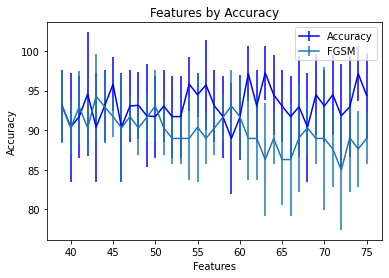

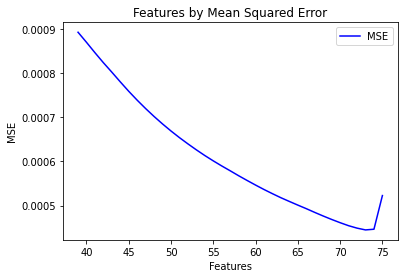

Dropping  Avg Fwd Segment Size
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 1ms/sample - loss: 0.6977 - accuracy: 0.5789
Epoch 2/10
57/57 [==============================] - 0s 99us/sample - loss: 0.6355 - accuracy: 0.7719
Epoch 3/10
57/57 [==============================] - 0s 105us/sample - loss: 0.5841 - accuracy: 0.8947
Epoch 4/10
57/57 [==============================] - 0s 89us/sample - loss: 0.5408 - accuracy: 0.9474
Epoch 5/10
57/57 [==============================] - 0s 64us/sample - loss: 0.5056 - accuracy: 0.9298
Epoch 6/10
57/57 [==============================] - 0s 68us/sample - loss: 0.4752 - accuracy: 0.9123
Epoch 7/10
57/57 [==============================] - 0s 109us/sample - loss: 0.4453 - accuracy: 0.9123
Epoch 8/10
57/57 [==============================] - 0s 89us/sample - loss: 0.4181 - accuracy: 0.9123
Epoch 9/10
57/57 [==============================] - 0s 83us/sample - loss: 0.3906 - accuracy: 0.9123
Epoch 10/10
15/15 [====================

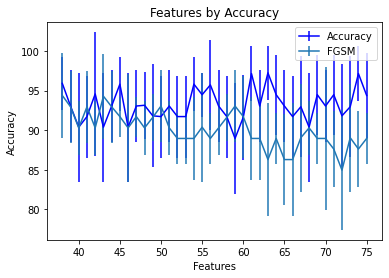

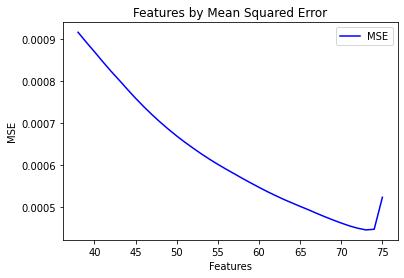

Dropping  Max Packet Length
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 1ms/sample - loss: 0.6977 - accuracy: 0.5088
Epoch 2/10
57/57 [==============================] - 0s 140us/sample - loss: 0.6438 - accuracy: 0.5088
Epoch 3/10
57/57 [==============================] - 0s 93us/sample - loss: 0.6008 - accuracy: 0.5614
Epoch 4/10
57/57 [==============================] - 0s 86us/sample - loss: 0.5640 - accuracy: 0.6491
Epoch 5/10
57/57 [==============================] - 0s 115us/sample - loss: 0.5352 - accuracy: 0.7368
Epoch 6/10
57/57 [==============================] - 0s 126us/sample - loss: 0.5062 - accuracy: 0.7895
Epoch 7/10
57/57 [==============================] - 0s 114us/sample - loss: 0.4792 - accuracy: 0.7895
Epoch 8/10
57/57 [==============================] - 0s 77us/sample - loss: 0.4540 - accuracy: 0.8947
Epoch 9/10
57/57 [==============================] - 0s 77us/sample - loss: 0.4296 - accuracy: 0.8947
Epoch 10/10
15/15 [=====================

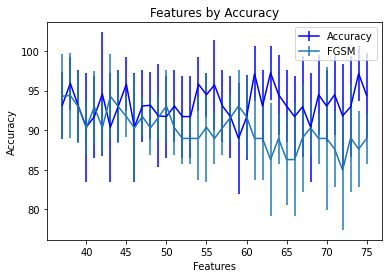

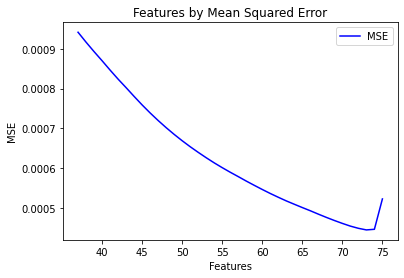

Dropping  Fwd Packet Length Std
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 1ms/sample - loss: 0.7467 - accuracy: 0.4912
Epoch 2/10
57/57 [==============================] - 0s 87us/sample - loss: 0.6563 - accuracy: 0.6667
Epoch 3/10
57/57 [==============================] - 0s 100us/sample - loss: 0.5803 - accuracy: 0.9123
Epoch 4/10
57/57 [==============================] - 0s 186us/sample - loss: 0.5274 - accuracy: 0.8947
Epoch 5/10
57/57 [==============================] - 0s 118us/sample - loss: 0.4879 - accuracy: 0.8947
Epoch 6/10
57/57 [==============================] - 0s 99us/sample - loss: 0.4542 - accuracy: 0.9123
Epoch 7/10
57/57 [==============================] - 0s 99us/sample - loss: 0.4223 - accuracy: 0.9123
Epoch 8/10
57/57 [==============================] - 0s 102us/sample - loss: 0.3931 - accuracy: 0.9123
Epoch 9/10
57/57 [==============================] - 0s 101us/sample - loss: 0.3649 - accuracy: 0.9298
Epoch 10/10
15/15 [================

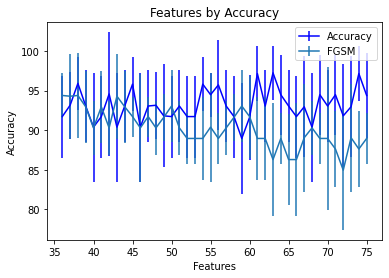

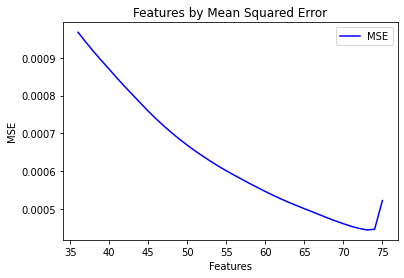

Dropping  Fwd IAT Std
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 1ms/sample - loss: 0.6286 - accuracy: 0.5088
Epoch 2/10
57/57 [==============================] - 0s 138us/sample - loss: 0.5790 - accuracy: 0.5439
Epoch 3/10
57/57 [==============================] - 0s 135us/sample - loss: 0.5397 - accuracy: 0.7719
Epoch 4/10
57/57 [==============================] - 0s 127us/sample - loss: 0.5074 - accuracy: 0.8772
Epoch 5/10
57/57 [==============================] - 0s 117us/sample - loss: 0.4779 - accuracy: 0.8947
Epoch 6/10
57/57 [==============================] - 0s 119us/sample - loss: 0.4514 - accuracy: 0.8947
Epoch 7/10
57/57 [==============================] - 0s 126us/sample - loss: 0.4269 - accuracy: 0.8947
Epoch 8/10
57/57 [==============================] - 0s 93us/sample - loss: 0.4021 - accuracy: 0.9298
Epoch 9/10
57/57 [==============================] - 0s 71us/sample - loss: 0.3778 - accuracy: 0.9474
Epoch 10/10
15/15 [=========================

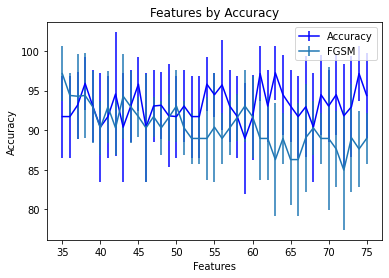

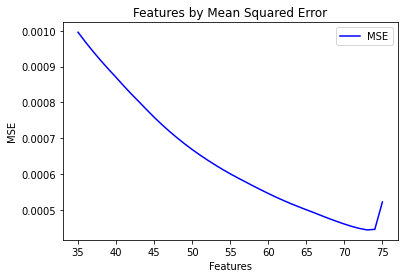

Dropping Idle Mean
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.6854 - accuracy: 0.6316
Epoch 2/10
57/57 [==============================] - 0s 90us/sample - loss: 0.6225 - accuracy: 0.8596
Epoch 3/10
57/57 [==============================] - 0s 79us/sample - loss: 0.5741 - accuracy: 0.8596
Epoch 4/10
57/57 [==============================] - 0s 126us/sample - loss: 0.5329 - accuracy: 0.8772
Epoch 5/10
57/57 [==============================] - 0s 85us/sample - loss: 0.4997 - accuracy: 0.8772
Epoch 6/10
57/57 [==============================] - 0s 102us/sample - loss: 0.4686 - accuracy: 0.8947
Epoch 7/10
57/57 [==============================] - 0s 92us/sample - loss: 0.4416 - accuracy: 0.8947
Epoch 8/10
57/57 [==============================] - 0s 128us/sample - loss: 0.4151 - accuracy: 0.8947
Epoch 9/10
57/57 [==============================] - 0s 114us/sample - loss: 0.3897 - accuracy: 0.9123
Epoch 10/10
15/15 [==============================

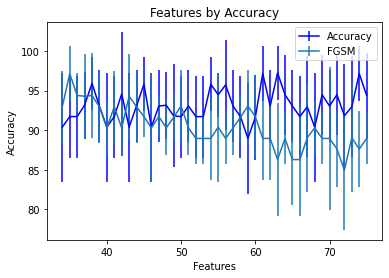

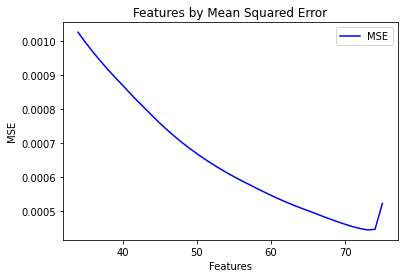

Dropping  Fwd Packet Length Min
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 1ms/sample - loss: 0.6857 - accuracy: 0.6140
Epoch 2/10
57/57 [==============================] - 0s 110us/sample - loss: 0.6062 - accuracy: 0.6842
Epoch 3/10
57/57 [==============================] - 0s 70us/sample - loss: 0.5543 - accuracy: 0.7719
Epoch 4/10
57/57 [==============================] - 0s 74us/sample - loss: 0.5112 - accuracy: 0.7895
Epoch 5/10
57/57 [==============================] - 0s 85us/sample - loss: 0.4790 - accuracy: 0.7895
Epoch 6/10
57/57 [==============================] - 0s 83us/sample - loss: 0.4519 - accuracy: 0.8421
Epoch 7/10
57/57 [==============================] - 0s 91us/sample - loss: 0.4271 - accuracy: 0.8947
Epoch 8/10
57/57 [==============================] - 0s 83us/sample - loss: 0.4035 - accuracy: 0.8947
Epoch 9/10
57/57 [==============================] - 0s 118us/sample - loss: 0.3804 - accuracy: 0.9298
Epoch 10/10
15/15 [===================

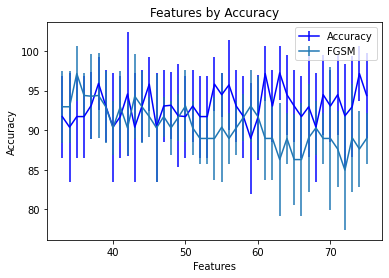

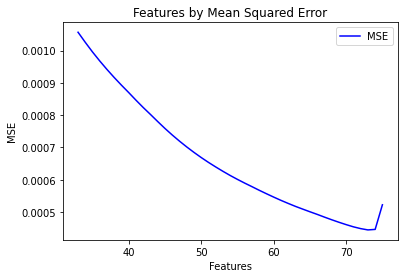

Dropping  PSH Flag Count
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 1ms/sample - loss: 0.7710 - accuracy: 0.4737
Epoch 2/10
57/57 [==============================] - 0s 118us/sample - loss: 0.6656 - accuracy: 0.7193
Epoch 3/10
57/57 [==============================] - 0s 130us/sample - loss: 0.5874 - accuracy: 0.8772
Epoch 4/10
57/57 [==============================] - 0s 90us/sample - loss: 0.5306 - accuracy: 0.8947
Epoch 5/10
57/57 [==============================] - 0s 105us/sample - loss: 0.4916 - accuracy: 0.8947
Epoch 6/10
57/57 [==============================] - 0s 121us/sample - loss: 0.4626 - accuracy: 0.8947
Epoch 7/10
57/57 [==============================] - 0s 114us/sample - loss: 0.4329 - accuracy: 0.8947
Epoch 8/10
57/57 [==============================] - 0s 137us/sample - loss: 0.4059 - accuracy: 0.8947
Epoch 9/10
57/57 [==============================] - 0s 118us/sample - loss: 0.3821 - accuracy: 0.8947
Epoch 10/10
15/15 [=====================

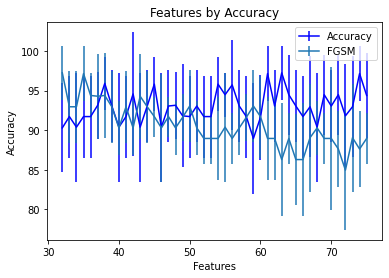

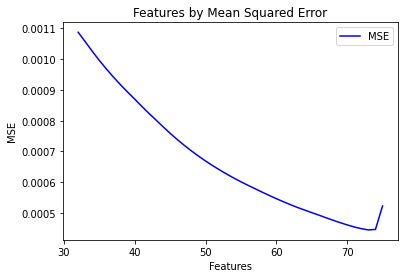

Dropping  Bwd IAT Std
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 1ms/sample - loss: 0.6977 - accuracy: 0.6491
Epoch 2/10
57/57 [==============================] - 0s 136us/sample - loss: 0.6149 - accuracy: 0.8596
Epoch 3/10
57/57 [==============================] - 0s 99us/sample - loss: 0.5528 - accuracy: 0.8070
Epoch 4/10
57/57 [==============================] - 0s 100us/sample - loss: 0.5036 - accuracy: 0.8246
Epoch 5/10
57/57 [==============================] - 0s 93us/sample - loss: 0.4700 - accuracy: 0.8596
Epoch 6/10
57/57 [==============================] - 0s 98us/sample - loss: 0.4384 - accuracy: 0.8596
Epoch 7/10
57/57 [==============================] - 0s 105us/sample - loss: 0.4118 - accuracy: 0.8772
Epoch 8/10
57/57 [==============================] - 0s 139us/sample - loss: 0.3882 - accuracy: 0.8947
Epoch 9/10
57/57 [==============================] - 0s 124us/sample - loss: 0.3647 - accuracy: 0.9123
Epoch 10/10
15/15 [==========================

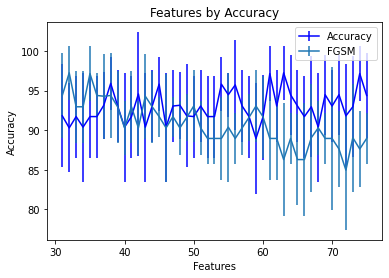

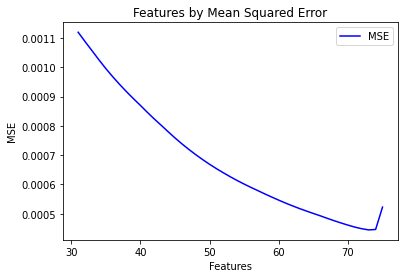

Dropping  Down/Up Ratio
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.6816 - accuracy: 0.7368
Epoch 2/10
57/57 [==============================] - 0s 109us/sample - loss: 0.6359 - accuracy: 0.8596
Epoch 3/10
57/57 [==============================] - 0s 101us/sample - loss: 0.6019 - accuracy: 0.8772
Epoch 4/10
57/57 [==============================] - 0s 100us/sample - loss: 0.5690 - accuracy: 0.8947
Epoch 5/10
57/57 [==============================] - 0s 102us/sample - loss: 0.5373 - accuracy: 0.8596
Epoch 6/10
57/57 [==============================] - 0s 86us/sample - loss: 0.5129 - accuracy: 0.8772
Epoch 7/10
57/57 [==============================] - 0s 132us/sample - loss: 0.4885 - accuracy: 0.8772
Epoch 8/10
57/57 [==============================] - 0s 105us/sample - loss: 0.4683 - accuracy: 0.8772
Epoch 9/10
57/57 [==============================] - 0s 87us/sample - loss: 0.4452 - accuracy: 0.8947
Epoch 10/10
15/15 [=======================

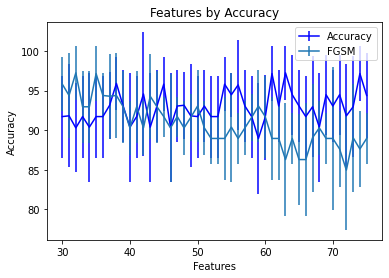

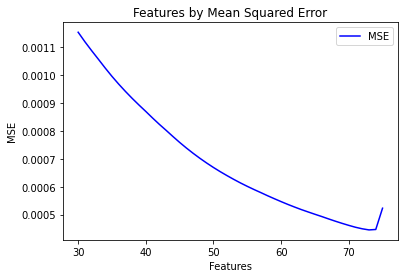

Dropping  Idle Max
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.6850 - accuracy: 0.5789
Epoch 2/10
57/57 [==============================] - 0s 102us/sample - loss: 0.6289 - accuracy: 0.8596
Epoch 3/10
57/57 [==============================] - 0s 119us/sample - loss: 0.5859 - accuracy: 0.8772
Epoch 4/10
57/57 [==============================] - 0s 77us/sample - loss: 0.5507 - accuracy: 0.8596
Epoch 5/10
57/57 [==============================] - 0s 84us/sample - loss: 0.5211 - accuracy: 0.8596
Epoch 6/10
57/57 [==============================] - 0s 88us/sample - loss: 0.4985 - accuracy: 0.8596
Epoch 7/10
57/57 [==============================] - 0s 111us/sample - loss: 0.4785 - accuracy: 0.8772
Epoch 8/10
57/57 [==============================] - 0s 90us/sample - loss: 0.4567 - accuracy: 0.8947
Epoch 9/10
57/57 [==============================] - 0s 100us/sample - loss: 0.4363 - accuracy: 0.8947
Epoch 10/10
15/15 [==============================

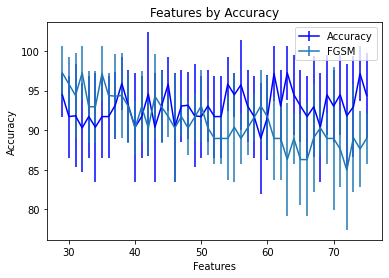

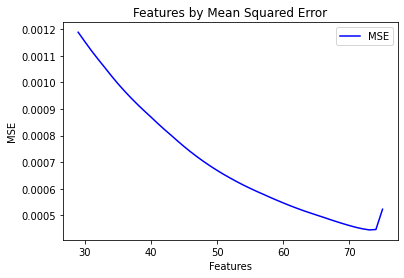

Dropping  Bwd IAT Max
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 1ms/sample - loss: 0.7234 - accuracy: 0.4912
Epoch 2/10
57/57 [==============================] - 0s 90us/sample - loss: 0.6545 - accuracy: 0.6667
Epoch 3/10
57/57 [==============================] - 0s 80us/sample - loss: 0.5990 - accuracy: 0.8421
Epoch 4/10
57/57 [==============================] - 0s 73us/sample - loss: 0.5475 - accuracy: 0.8421
Epoch 5/10
57/57 [==============================] - 0s 89us/sample - loss: 0.5067 - accuracy: 0.8596
Epoch 6/10
57/57 [==============================] - 0s 92us/sample - loss: 0.4720 - accuracy: 0.9123
Epoch 7/10
57/57 [==============================] - 0s 103us/sample - loss: 0.4407 - accuracy: 0.9123
Epoch 8/10
57/57 [==============================] - 0s 115us/sample - loss: 0.4134 - accuracy: 0.9123
Epoch 9/10
57/57 [==============================] - 0s 129us/sample - loss: 0.3876 - accuracy: 0.9123
Epoch 10/10
15/15 [============================

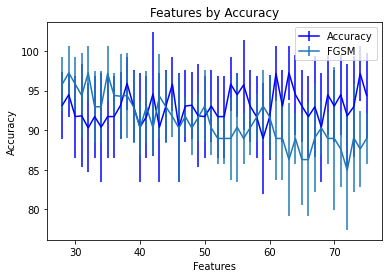

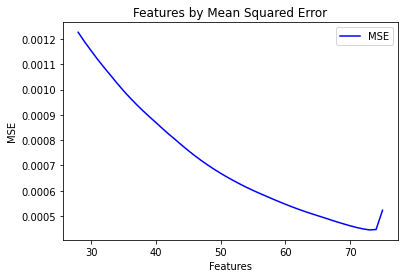

Dropping  min_seg_size_forward
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 1ms/sample - loss: 0.6923 - accuracy: 0.4386
Epoch 2/10
57/57 [==============================] - 0s 101us/sample - loss: 0.6346 - accuracy: 0.6140
Epoch 3/10
57/57 [==============================] - 0s 61us/sample - loss: 0.5903 - accuracy: 0.7895
Epoch 4/10
57/57 [==============================] - 0s 91us/sample - loss: 0.5554 - accuracy: 0.7895
Epoch 5/10
57/57 [==============================] - 0s 90us/sample - loss: 0.5307 - accuracy: 0.7895
Epoch 6/10
57/57 [==============================] - 0s 85us/sample - loss: 0.5095 - accuracy: 0.7895
Epoch 7/10
57/57 [==============================] - 0s 78us/sample - loss: 0.4940 - accuracy: 0.7895
Epoch 8/10
57/57 [==============================] - 0s 113us/sample - loss: 0.4774 - accuracy: 0.7895
Epoch 9/10
57/57 [==============================] - 0s 103us/sample - loss: 0.4627 - accuracy: 0.7895
Epoch 10/10
15/15 [===================

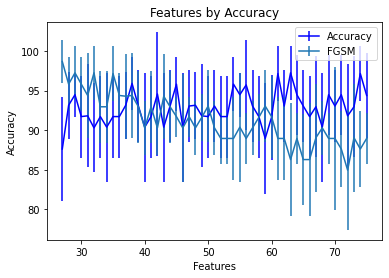

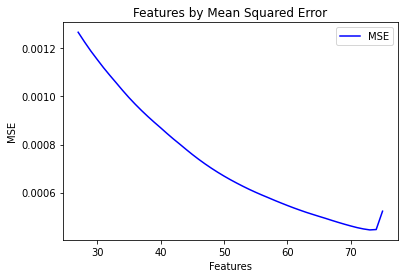

Dropping  Fwd IAT Max
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 1ms/sample - loss: 0.7607 - accuracy: 0.4386
Epoch 2/10
57/57 [==============================] - 0s 111us/sample - loss: 0.7076 - accuracy: 0.2632
Epoch 3/10
57/57 [==============================] - 0s 123us/sample - loss: 0.6635 - accuracy: 0.6316
Epoch 4/10
57/57 [==============================] - 0s 94us/sample - loss: 0.6296 - accuracy: 0.8596
Epoch 5/10
57/57 [==============================] - 0s 92us/sample - loss: 0.6001 - accuracy: 0.8947
Epoch 6/10
57/57 [==============================] - 0s 108us/sample - loss: 0.5757 - accuracy: 0.8947
Epoch 7/10
57/57 [==============================] - 0s 106us/sample - loss: 0.5550 - accuracy: 0.8947
Epoch 8/10
57/57 [==============================] - 0s 101us/sample - loss: 0.5345 - accuracy: 0.8947
Epoch 9/10
57/57 [==============================] - 0s 100us/sample - loss: 0.5152 - accuracy: 0.8947
Epoch 10/10
15/15 [=========================

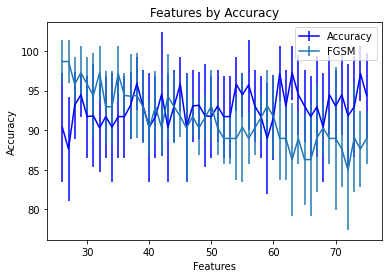

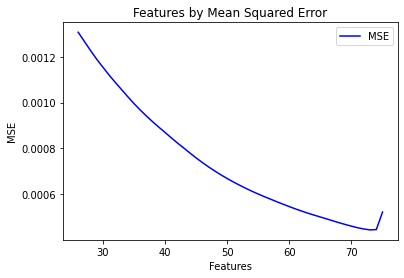

Dropping  Flow IAT Max
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.7411 - accuracy: 0.3860
Epoch 2/10
57/57 [==============================] - 0s 103us/sample - loss: 0.6790 - accuracy: 0.6842
Epoch 3/10
57/57 [==============================] - 0s 62us/sample - loss: 0.6198 - accuracy: 0.9298
Epoch 4/10
57/57 [==============================] - 0s 89us/sample - loss: 0.5770 - accuracy: 0.8947
Epoch 5/10
57/57 [==============================] - 0s 94us/sample - loss: 0.5424 - accuracy: 0.8596
Epoch 6/10
57/57 [==============================] - 0s 93us/sample - loss: 0.5102 - accuracy: 0.8596
Epoch 7/10
57/57 [==============================] - 0s 95us/sample - loss: 0.4854 - accuracy: 0.8596
Epoch 8/10
57/57 [==============================] - 0s 84us/sample - loss: 0.4604 - accuracy: 0.8596
Epoch 9/10
57/57 [==============================] - 0s 79us/sample - loss: 0.4397 - accuracy: 0.8596
Epoch 10/10
15/15 [=============================

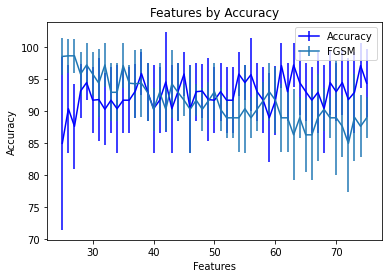

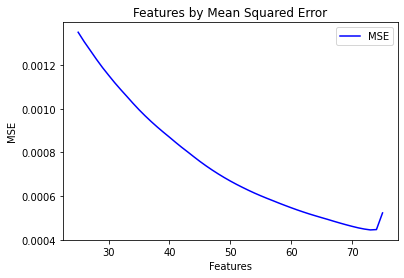

Dropping Fwd PSH Flags
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.6462 - accuracy: 0.5439
Epoch 2/10
57/57 [==============================] - 0s 126us/sample - loss: 0.5982 - accuracy: 0.7368
Epoch 3/10
57/57 [==============================] - 0s 125us/sample - loss: 0.5676 - accuracy: 0.8947
Epoch 4/10
57/57 [==============================] - 0s 77us/sample - loss: 0.5390 - accuracy: 0.8947
Epoch 5/10
57/57 [==============================] - 0s 80us/sample - loss: 0.5145 - accuracy: 0.8947
Epoch 6/10
57/57 [==============================] - 0s 77us/sample - loss: 0.4928 - accuracy: 0.8947
Epoch 7/10
57/57 [==============================] - 0s 95us/sample - loss: 0.4729 - accuracy: 0.8947
Epoch 8/10
57/57 [==============================] - 0s 105us/sample - loss: 0.4539 - accuracy: 0.8947
Epoch 9/10
57/57 [==============================] - 0s 84us/sample - loss: 0.4358 - accuracy: 0.8947
Epoch 10/10
15/15 [===========================

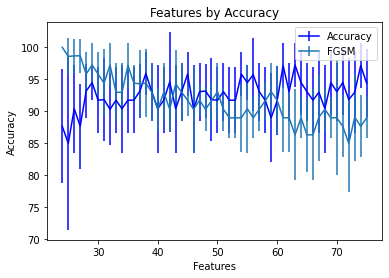

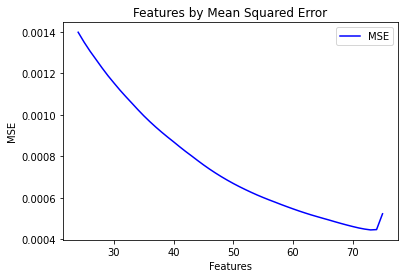

Dropping  SYN Flag Count
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 2ms/sample - loss: 0.6167 - accuracy: 0.7018
Epoch 2/10
57/57 [==============================] - 0s 136us/sample - loss: 0.5718 - accuracy: 0.8596
Epoch 3/10
57/57 [==============================] - 0s 94us/sample - loss: 0.5345 - accuracy: 0.8596
Epoch 4/10
57/57 [==============================] - 0s 82us/sample - loss: 0.5055 - accuracy: 0.8772
Epoch 5/10
57/57 [==============================] - 0s 152us/sample - loss: 0.4856 - accuracy: 0.8772
Epoch 6/10
57/57 [==============================] - 0s 132us/sample - loss: 0.4642 - accuracy: 0.8772
Epoch 7/10
57/57 [==============================] - 0s 129us/sample - loss: 0.4471 - accuracy: 0.8772
Epoch 8/10
57/57 [==============================] - 0s 94us/sample - loss: 0.4286 - accuracy: 0.8772
Epoch 9/10
57/57 [==============================] - 0s 75us/sample - loss: 0.4095 - accuracy: 0.8947
Epoch 10/10
15/15 [========================

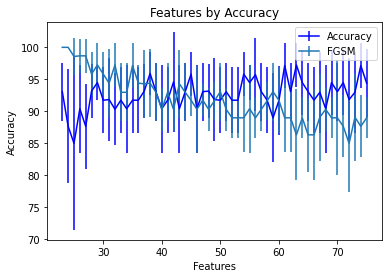

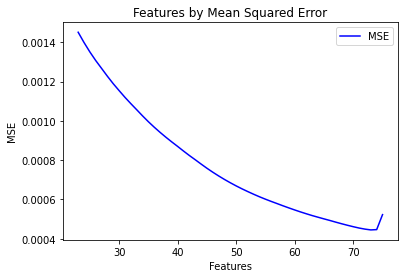

Dropping Fwd IAT Total
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 1ms/sample - loss: 0.7139 - accuracy: 0.5263
Epoch 2/10
57/57 [==============================] - 0s 90us/sample - loss: 0.6564 - accuracy: 0.8246
Epoch 3/10
57/57 [==============================] - 0s 77us/sample - loss: 0.6040 - accuracy: 0.9123
Epoch 4/10
57/57 [==============================] - 0s 80us/sample - loss: 0.5654 - accuracy: 0.9123
Epoch 5/10
57/57 [==============================] - 0s 71us/sample - loss: 0.5326 - accuracy: 0.9123
Epoch 6/10
57/57 [==============================] - 0s 103us/sample - loss: 0.5050 - accuracy: 0.9123
Epoch 7/10
57/57 [==============================] - 0s 79us/sample - loss: 0.4790 - accuracy: 0.9123
Epoch 8/10
57/57 [==============================] - 0s 72us/sample - loss: 0.4548 - accuracy: 0.9123
Epoch 9/10
57/57 [==============================] - 0s 91us/sample - loss: 0.4316 - accuracy: 0.9123
Epoch 10/10
15/15 [=============================

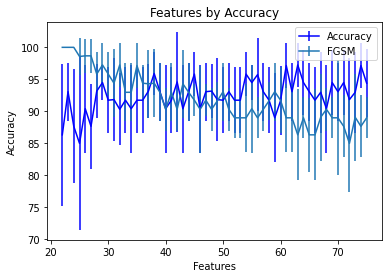

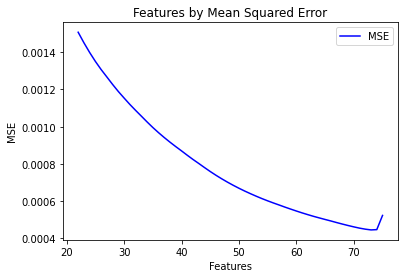

Dropping Bwd IAT Total
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 1ms/sample - loss: 0.6943 - accuracy: 0.5789
Epoch 2/10
57/57 [==============================] - 0s 89us/sample - loss: 0.6502 - accuracy: 0.8947
Epoch 3/10
57/57 [==============================] - 0s 84us/sample - loss: 0.6137 - accuracy: 0.9123
Epoch 4/10
57/57 [==============================] - 0s 89us/sample - loss: 0.5793 - accuracy: 0.9298
Epoch 5/10
57/57 [==============================] - 0s 80us/sample - loss: 0.5496 - accuracy: 0.9298
Epoch 6/10
57/57 [==============================] - 0s 76us/sample - loss: 0.5212 - accuracy: 0.9298
Epoch 7/10
57/57 [==============================] - 0s 75us/sample - loss: 0.4949 - accuracy: 0.9298
Epoch 8/10
57/57 [==============================] - 0s 141us/sample - loss: 0.4718 - accuracy: 0.9474
Epoch 9/10
57/57 [==============================] - 0s 141us/sample - loss: 0.4469 - accuracy: 0.9474
Epoch 10/10
15/15 [============================

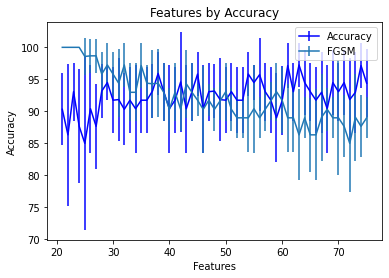

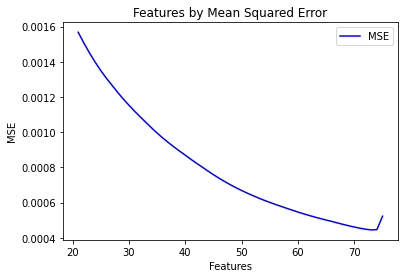

Dropping  ACK Flag Count
Train on 57 samples
Epoch 1/10
57/57 [==============================] - 0s 1ms/sample - loss: 0.7005 - accuracy: 0.3509
Epoch 2/10
57/57 [==============================] - 0s 103us/sample - loss: 0.6600 - accuracy: 0.8772
Epoch 3/10
57/57 [==============================] - 0s 84us/sample - loss: 0.6201 - accuracy: 0.9298
Epoch 4/10
57/57 [==============================] - 0s 122us/sample - loss: 0.5878 - accuracy: 0.9123
Epoch 5/10
57/57 [==============================] - 0s 132us/sample - loss: 0.5546 - accuracy: 0.9123
Epoch 6/10
57/57 [==============================] - 0s 92us/sample - loss: 0.5242 - accuracy: 0.9123
Epoch 7/10
57/57 [==============================] - 0s 120us/sample - loss: 0.4984 - accuracy: 0.9123
Epoch 8/10
57/57 [==============================] - 0s 70us/sample - loss: 0.4703 - accuracy: 0.9123
Epoch 9/10
57/57 [==============================] - 0s 88us/sample - loss: 0.4453 - accuracy: 0.9123
Epoch 10/10
15/15 [========================

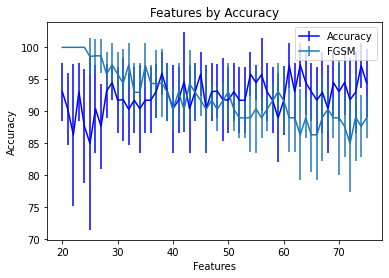

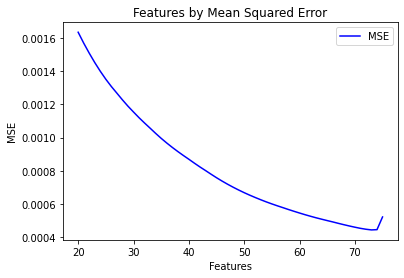

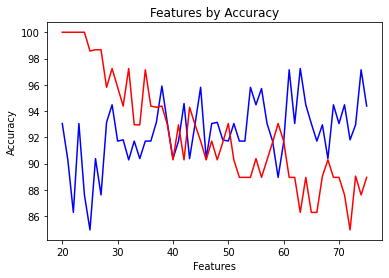

No handles with labels found to put in legend.


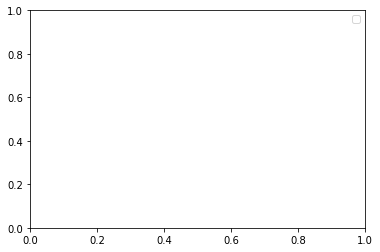

ValueError: ignored

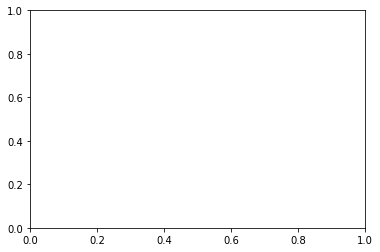

In [ ]:
# Import the attack
from cleverhans.future.tf2.attacks import fast_gradient_method

features = []
accuracys = []
mseerrors = []
minmseerrors = []
test_accuracys = []

mean_accuracy = []
std_accuracy = []

mean_fgsm_accuracy = []
std_fgsm_accuracy = []

best_case_fgsm = []
worst_case_fgsm = []

mean_mses = []
std_mses = []

#features_sorted_biggest_difference = [' PSH Flag Count', ' ACK Flag Count', 'Bwd Packet Length Max', ' Max Packet Length', ' Packet Length Mean', ' Average Packet Size', ' Packet Length Std', ' Avg Bwd Segment Size', ' Flow Packets/s', ' min_seg_size_forward', ' Bwd Packet Length Std', ' Bwd Packet Length Mean', ' Packet Length Variance', 'Fwd IAT Total', ' URG Flag Count', ' Down/Up Ratio', ' Fwd IAT Max', ' Flow IAT Max', 'Init_Win_bytes_forward', 'Idle Mean', ' Fwd IAT Std', ' Flow IAT Std', 'Bwd IAT Total', 'Fwd PSH Flags', ' SYN Flag Count', ' Fwd Packet Length Mean', ' Avg Fwd Segment Size', ' Bwd IAT Max', ' Fwd Packet Length Std', ' Fwd IAT Mean', ' Flow IAT Mean', ' Fwd Packet Length Min', ' Init_Win_bytes_backward', ' Bwd IAT Std', 'Flow Bytes/s', 'FIN Flag Count', ' Fwd IAT Min', ' Bwd IAT Min', ' Subflow Bwd Bytes', ' Fwd Header Length', ' Fwd Header Length.1', ' Active Min', ' act_data_pkt_fwd', 'Active Mean', 'Subflow Fwd Packets', ' Active Max', ' Bwd Header Length', ' Subflow Bwd Packets', 'Fwd Packets/s', ' RST Flag Count', ' ECE Flag Count', ' Flow IAT Min', ' Active Std', ' Bwd Packets/s', ' Bwd IAT Mean', ' Subflow Fwd Bytes', ' Min Packet Length', ' Bwd Packet Length Min']

#features_sorted_biggest_difference = [' PSH Flag Count', ' ACK Flag Count', 'Bwd Packet Length Max', ' Max Packet Length', ' Packet Length Mean', ' Average Packet Size', ' Packet Length Std', ' Avg Bwd Segment Size', ' min_seg_size_forward', ' Bwd Packet Length Std', ' Bwd Packet Length Mean', ' Packet Length Variance', 'Fwd IAT Total', ' URG Flag Count', ' Down/Up Ratio', ' Fwd IAT Max', ' Flow IAT Max', 'Init_Win_bytes_forward', 'Idle Mean', ' Fwd IAT Std', ' Flow IAT Std', 'Bwd IAT Total', 'Fwd PSH Flags', ' SYN Flag Count', ' Fwd Packet Length Mean', ' Avg Fwd Segment Size', ' Bwd IAT Max', ' Fwd Packet Length Std', ' Fwd IAT Mean', ' Flow IAT Mean', ' Fwd Packet Length Min', ' Init_Win_bytes_backward', ' Bwd IAT Std', 'Flow Bytes/s', 'FIN Flag Count', ' Fwd IAT Min', ' Bwd IAT Min', ' Subflow Bwd Bytes', ' Fwd Header Length', ' Fwd Header Length.1', ' Active Min', ' act_data_pkt_fwd', 'Active Mean', 'Subflow Fwd Packets', ' Active Max', ' Bwd Header Length', ' Subflow Bwd Packets', 'Fwd Packets/s', ' RST Flag Count', ' ECE Flag Count', ' Flow IAT Min', ' Active Std', ' Bwd Packets/s', ' Bwd IAT Mean', ' Subflow Fwd Bytes', ' Min Packet Length', ' Bwd Packet Length Min']

#features_sorted_biggest_difference = [' PSH Flag Count', ' ACK Flag Count', 'Bwd Packet Length Max', ' Max Packet Length', ' Packet Length Mean', ' Average Packet Size', ' Packet Length Std', ' Avg Bwd Segment Size', ' min_seg_size_forward', ' Bwd Packet Length Std', ' Bwd Packet Length Mean', ' Packet Length Variance', 'Fwd IAT Total', ' URG Flag Count', ' Down/Up Ratio', ' Fwd IAT Max', ' Flow IAT Max', 'Init_Win_bytes_forward', 'Idle Mean', ' Fwd IAT Std', ' Flow IAT Std', 'Bwd IAT Total', 'Fwd PSH Flags', ' SYN Flag Count', ' Fwd Packet Length Mean', ' Avg Fwd Segment Size', ' Bwd IAT Max', ' Fwd Packet Length Std', ' Fwd IAT Mean', ' Flow IAT Mean', ' Fwd Packet Length Min', ' Init_Win_bytes_backward', ' Bwd IAT Std', 'FIN Flag Count', ' Fwd IAT Min', ' Bwd IAT Min', ' Subflow Bwd Bytes', ' Fwd Header Length', ' Fwd Header Length.1', ' Active Min', ' act_data_pkt_fwd', 'Active Mean', 'Subflow Fwd Packets', ' Active Max', ' Bwd Header Length', ' Subflow Bwd Packets', 'Fwd Packets/s', ' RST Flag Count', ' ECE Flag Count', ' Flow IAT Min', ' Active Std', ' Bwd Packets/s', ' Bwd IAT Mean', ' Subflow Fwd Bytes', ' Min Packet Length', ' Bwd Packet Length Min']


#Bot Features
#features_sorted_biggest_difference = [' PSH Flag Count', ' ACK Flag Count', ' URG Flag Count', 'Init_Win_bytes_forward', 'Fwd IAT Total', 'Bwd IAT Total', 'Fwd PSH Flags', ' SYN Flag Count', ' Init_Win_bytes_backward', ' min_seg_size_forward', 'Fwd Packets/s', ' Bwd Packet Length Std', 'FIN Flag Count', ' Avg Fwd Segment Size', ' Fwd Packet Length Mean', ' Down/Up Ratio', ' Flow Packets/s', ' Bwd IAT Min', ' Fwd IAT Min', ' Fwd Packet Length Std', ' Bwd IAT Max', ' Fwd IAT Max', ' Flow IAT Max', ' Packet Length Variance', ' Bwd Packets/s', 'Idle Mean', ' Bwd IAT Mean', ' Fwd IAT Mean', ' Packet Length Std', ' Max Packet Length', ' Subflow Fwd Bytes', ' Flow IAT Min', ' Fwd Header Length', ' Subflow Bwd Bytes', ' RST Flag Count', ' ECE Flag Count', ' Bwd Header Length', ' act_data_pkt_fwd', ' Subflow Bwd Packets', 'Subflow Fwd Packets', ' Fwd Header Length.1', ' Flow IAT Std', 'Flow Bytes/s', ' Active Min', 'Active Mean', ' Active Std', ' Packet Length Mean', ' Active Max', ' Flow IAT Mean', ' Bwd IAT Std', ' Fwd IAT Std', ' Average Packet Size', ' Fwd Packet Length Min', 'Bwd Packet Length Max', ' Bwd Packet Length Mean', ' Avg Bwd Segment Size', ' Min Packet Length', ' Bwd Packet Length Min']
#features_sorted_biggest_difference = [' PSH Flag Count', ' ACK Flag Count', ' URG Flag Count', 'Init_Win_bytes_forward', 'Fwd IAT Total', 'Bwd IAT Total', 'Fwd PSH Flags', ' SYN Flag Count', ' Init_Win_bytes_backward', ' min_seg_size_forward', 'Fwd Packets/s', ' Bwd Packet Length Std', 'FIN Flag Count', ' Avg Fwd Segment Size', ' Fwd Packet Length Mean', ' Down/Up Ratio', ' Bwd IAT Min', ' Fwd IAT Min', ' Fwd Packet Length Std', ' Bwd IAT Max', ' Fwd IAT Max', ' Flow IAT Max', ' Packet Length Variance', ' Bwd Packets/s', 'Idle Mean', ' Bwd IAT Mean', ' Fwd IAT Mean', ' Packet Length Std', ' Max Packet Length', ' Subflow Fwd Bytes', ' Flow IAT Min', ' Fwd Header Length', ' Subflow Bwd Bytes', ' RST Flag Count', ' ECE Flag Count', ' Bwd Header Length', ' act_data_pkt_fwd', ' Subflow Bwd Packets', 'Subflow Fwd Packets', ' Fwd Header Length.1', ' Flow IAT Std', ' Active Min', 'Active Mean', ' Active Std', ' Packet Length Mean', ' Active Max', ' Flow IAT Mean', ' Bwd IAT Std', ' Fwd IAT Std', ' Average Packet Size', ' Fwd Packet Length Min', 'Bwd Packet Length Max', ' Bwd Packet Length Mean', ' Avg Bwd Segment Size', ' Min Packet Length', ' Bwd Packet Length Min']


#Infiltration Features

#features_sorted_biggest_difference = [' Avg Bwd Segment Size', 'FIN Flag Count', ' Subflow Bwd Bytes', ' Bwd Packet Length Mean', 'Bwd Packet Length Max', ' Init_Win_bytes_backward', ' Flow Packets/s', 'Flow Bytes/s', ' Bwd IAT Min', 'Fwd Packets/s', ' Flow IAT Min', ' Bwd Packet Length Std', ' Fwd IAT Min', ' Bwd Packets/s', ' Active Std', 'Init_Win_bytes_forward', ' Fwd IAT Mean', ' Flow IAT Mean', ' Packet Length Variance', ' Active Min', ' URG Flag Count', ' Average Packet Size', ' Bwd IAT Mean', 'Active Mean', ' Subflow Fwd Bytes', ' Packet Length Mean', 'Subflow Fwd Packets', ' Active Max', ' Subflow Bwd Packets', ' Fwd Header Length', ' Fwd Header Length.1', ' Bwd Header Length', ' act_data_pkt_fwd', ' Flow IAT Std', ' Bwd Packet Length Min', ' Fwd Packet Length Mean', ' Idle Std', ' Min Packet Length', ' Packet Length Std', ' Avg Fwd Segment Size', ' Max Packet Length', ' Fwd Packet Length Std', ' Fwd IAT Std', 'Idle Mean', ' Fwd Packet Length Min', ' PSH Flag Count', ' Bwd IAT Std', ' Down/Up Ratio', ' Idle Max', ' Bwd IAT Max', ' min_seg_size_forward', ' Fwd IAT Max', ' Flow IAT Max', 'Fwd PSH Flags', ' SYN Flag Count', 'Fwd IAT Total', 'Bwd IAT Total', ' ACK Flag Count']
features_sorted_biggest_difference = [' Avg Bwd Segment Size', 'FIN Flag Count', ' Subflow Bwd Bytes', ' Bwd Packet Length Mean', 'Bwd Packet Length Max', ' Init_Win_bytes_backward', ' Bwd IAT Min', 'Fwd Packets/s', ' Flow IAT Min', ' Bwd Packet Length Std', ' Fwd IAT Min', ' Bwd Packets/s', ' Active Std', 'Init_Win_bytes_forward', ' Fwd IAT Mean', ' Flow IAT Mean', ' Packet Length Variance', ' Active Min', ' URG Flag Count', ' Average Packet Size', ' Bwd IAT Mean', 'Active Mean', ' Subflow Fwd Bytes', ' Packet Length Mean', 'Subflow Fwd Packets', ' Active Max', ' Subflow Bwd Packets', ' Fwd Header Length', ' Fwd Header Length.1', ' Bwd Header Length', ' act_data_pkt_fwd', ' Flow IAT Std', ' Bwd Packet Length Min', ' Fwd Packet Length Mean', ' Idle Std', ' Min Packet Length', ' Packet Length Std', ' Avg Fwd Segment Size', ' Max Packet Length', ' Fwd Packet Length Std', ' Fwd IAT Std', 'Idle Mean', ' Fwd Packet Length Min', ' PSH Flag Count', ' Bwd IAT Std', ' Down/Up Ratio', ' Idle Max', ' Bwd IAT Max', ' min_seg_size_forward', ' Fwd IAT Max', ' Flow IAT Max', 'Fwd PSH Flags', ' SYN Flag Count', 'Fwd IAT Total', 'Bwd IAT Total', ' ACK Flag Count']


num_features = 76

for feature_to_drop in features_sorted_biggest_difference:
  print("Dropping {}".format(feature_to_drop))
  dataset = dataset.drop(columns=feature_to_drop)
  X = dataset
  num_features = num_features -1

  # Performing scale data
  scaler = MinMaxScaler().fit(X)
  X_scaled = np.array(scaler.transform(X))

  
  #X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_class, test_size = 0.7, shuffle=True, random_state = 42, stratify=Y_class)

  kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  cvscores = []
  fgsmcvscores = []
  for train, test in kfold.split(X_scaled, Y_class):
    # create model

    
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=[X_scaled[train].shape[1]]),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(len(np.unique(Y_class))),
        tf.keras.layers.Activation(tf.nn.softmax)
    ])






    model.compile(optimizer='adam',
                  #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  loss= 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])

  
    model.fit(X_scaled[train], Y_class[train], epochs=10)
  
    #test_loss, test_acc = model.evaluate(X_test, Y_test)
    scores = model.evaluate(X_scaled[test], Y_class[test])
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    #print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
  
    print("======\n")
    print('Number of features\t  Test accuracy:')
    #print("{}\t{}".format(num_features, test_acc))
    #features.append(num_features+1)
    #accuracys.append(test_acc)
    #print("{}\t{}".format(features,accuracys))

    #The attack requires the model to ouput the logits
    logits_model = tf.keras.Model(model.input,model.layers[-1].output)

    # Batch run on all test data

    CLASS_TO_CHANGE = 1 # 1 will make all true cases appear as false

    X_adv = np.zeros(X_scaled[test].shape)

    print (X_scaled[test].shape)


    for i in range(X_scaled[test].shape[0]):
      current_class = Y_class[test][i]
      #print("Class:", current_class)
      if current_class == CLASS_TO_CHANGE:
          example_vals = X_scaled[test][i, :]
          example_labels = Y_class[test][i]
          example_vals = tf.convert_to_tensor(example_vals.reshape((1, num_features+1)))
          example_labels = np.reshape(example_labels, (1,)).astype('int64')
          epsilon = 0.05
          adv_example_untargeted_label = fast_gradient_method(logits_model, example_vals, epsilon, np.inf, targeted=False)
          adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)
    
          X_adv[i,:] = adv_example_untargeted_label
          #X_test[i,:] = adv_example_untargeted_label
          #print (example_labels, "--->", np.argmax(adv_example_untargeted_label_pred))
          #print(X_test[i,:])
          #outputfile= pd.DataFrame(X_test[i,:])
          #outputfile.to_csv('mount/My Drive/Colab Notebooks/network_data/adversarial.csv')

    print("This is where the Adversarial Example is")
    print(X_adv)
    for i in range(X_adv.shape[0]):
        #print(X_test[i])
        #print(".")
        #print(example_vals) 
        pass

    #outputfile = pd.DataFrame(X_test)
    #outputfile.to_csv('mount/My Drive/Colab Notebooks/network_data/adversarial.csv')
    #sys.exit()

    #find overall difference
    error = (X_scaled[test] - X_adv)
    #print (error)
    #find MeanSquaredError
    mse = tf.reduce_mean(tf.square(error, name="mse"))
    mseerrors.append(mse)

    mean_mses.append(np.mean(mseerrors))
    std_mses.append(np.std(mseerrors))
  


    fgsmscores = model.evaluate(X_adv, Y_class[test])
    print("%s: %.2f%%" % (model.metrics_names[1], fgsmscores[1]*100))
    fgsmcvscores.append(fgsmscores[1] * 100)
    #print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    #test_loss, test_acc = model.evaluate(X_test, Y_test)
    #print('FGSM accuracy:', test_acc)
    #test_accuracys.append(test_acc)
    #print("{}\n{}\n{}".format(features,accuracys,test_accuracys))

    from sklearn.metrics import classification_report

    y_pred = model.predict(X_adv, batch_size=64, verbose=1)
    y_pred_bool = np.argmax(y_pred, axis=1)

    print(classification_report(Y_class[test], y_pred_bool))

  features.append(num_features)
  mean_accuracy.append(np.mean(cvscores))
  std_accuracy.append(np.std(cvscores))

  mean_fgsm_accuracy.append(np.mean(fgsmcvscores))
  std_fgsm_accuracy.append(np.std(fgsmcvscores))
  best_case_fgsm.append(np.mean(fgsmcvscores) + np.std(fgsmcvscores))
  worst_case_fgsm.append(np.mean(fgsmcvscores) - np.std(fgsmcvscores))


  print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
  print("%.2f%% (+/- %.2f%%)" % (np.mean(fgsmcvscores), np.std(fgsmcvscores)))
    
  print("Results_Table") 

  results_table = np.column_stack([features, mean_accuracy, std_accuracy, mean_fgsm_accuracy, std_fgsm_accuracy, best_case_fgsm, worst_case_fgsm])

  print(results_table)
  np.savetxt("mount/My Drive/Colab Notebooks/CICIDS2017/results_table.csv", results_table, delimiter=",")
  
  #plt.plot(features, mean_accuracy, linestyle='solid', c='b', label='Accuracy')
  plt.errorbar(features, mean_accuracy, yerr=std_accuracy, linestyle='solid', c='b', label='Accuracy')
  #plt.plot(features, mean_fgsm_accuracy, linestyle='solid', c='r', label='Accuracy under attack')
  plt.errorbar(features, mean_fgsm_accuracy, yerr=std_fgsm_accuracy, xlolims=True, label='FGSM')
  plt.xlabel('Features')
  plt.ylabel('Accuracy')
  plt.title('Features by Accuracy')
  plt.legend(loc='best')
  plt.show()

  #Fudge the MSEs before printing 
  #Take only every fifth 

  mse_fifth = []

  for i in range(0,len(mean_mses),5):
    mse_fifth.append(mean_mses[i])
  

  mse_for_plot = []

  for i in range(0, len(mse_fifth)):
    mse_for_plot.append(mse_fifth[i]/features[i])
    


  plt.plot(features, mse_for_plot, linestyle='solid', c='b', label='MSE')
  plt.legend(loc='best')
  plt.xlabel('Features')
  plt.ylabel('MSE')
  plt.title('Features by Mean Squared Error')
  plt.show()


plt.plot(features, mean_accuracy, linestyle='solid', c='b', label='Accuracy')
plt.plot(features, mean_fgsm_accuracy, linestyle='solid', c='r', label='FGSM')

plt.xlabel('Features')
#xticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
#plt.xticks(xticks,xticks)
plt.ylabel('Accuracy')
plt.title('Features by Accuracy')
plt.show()


#plt.scatter(mserrors[1], mserrors[1])

#plt.scatter(X[:9999, 0], X[:9999, 1], color='blue', alpha=0.4, label='Original Data')



#plt.scatter(Xadv[:9999, 0], Xadv[:9999, 1], color='green', alpha=0.4, label='Adversarial Examples, Epsilon = 0.2')
#plt.scatter(Xadv2[:9999, 0], Xadv2[:9999, 1], color='purple', alpha=0.4, label='Adversarial Examples, Epsilon = 0.5')
#plt.scatter(X[10000:, 0], X[10000:, 1], color='red', alpha=0.4, label='Original Data')
#plt.scatter(Xadv[10000:, 0], Xadv[10000:, 1], color='orange', alpha=0.4, label='Adversarial Examples, Epsilon = 0.2')
#plt.scatter(Xadv2[10000:, 0], Xadv2[10000:, 1], color='yellow', alpha=0.4, label='Adversarial Examples, Epsilon = 0.5')
plt.legend(loc='best')
plt.show()


plt.plot(features, mseerrors, linestyle='solid', c='b', label='MSE')
plt.legend(loc='best')
plt.xlabel('Features')
plt.ylabel('MSE')
plt.title('Features by Mean Squared Error')

plt.show()

In [ ]:
plt.plot(features, mean_accuracy, linestyle='solid', c='b', label='Accuracy')
plt.plot(features, mean_fgsm_accuracy, linestyle='solid', c='r', label='Accuracy under attack')
plt.errorbar(features, mean_fgsm_accuracy, yerr=std_fgsm_accuracy, xlolims=True, label='xlolims=True')
plt.xlabel('Features')
plt.ylabel('Accuracy')
plt.title('Features by Accuracy')
plt.legend(loc='best')
plt.show()


In [ ]:
#results_table = np.column_stack([features, mean_accuracy, std_accuracy, mean_fgsm_accuracy, std_fgsm_accuracy, best_case_fgsm, worst_case_fgsm])

print(results_table)

#np.savetxt("mount/My Drive/Colab Notebooks/CICIDS2017/results_table.csv", results_table, delimiter=",")

plt.scatter(features, mean_accuracy, linestyle='solid', c='b', label='Accuracy')
plt.scatter(features, mean_fgsm_accuracy, linestyle='solid', c='r', label='Accuracy under attack')
plt.xlabel('Features')
#xticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
#plt.xticks(xticks,xticks)
plt.ylabel('Accuracy')
plt.title('Features by Accuracy')
plt.legend(loc='best')
plt.show()

In [ ]:
# Import the attack
from cleverhans.future.tf2.attacks import fast_gradient_method

#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(model.input,model.layers[-1].output)

In [ ]:
# Get a random test case
ra = np.random.randint(X_test.shape[0])
print ("Index:",ra)
example_vals = X_test[ra, :]
example_labels = Y_test[ra]
#example_labels = Y_attack[ra]

example_vals = tf.convert_to_tensor(example_vals.reshape((1, 77)))
example_labels = np.reshape(example_labels, (1,)).astype('int64')

print ("Values:",example_vals)
print ("Label:", example_labels)

In [ ]:
# Non-Targeted Attack

epsilon = 0.1

adv_example_untargeted_label = fast_gradient_method(logits_model, example_vals, epsilon, np.inf, targeted=False)
adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)

print ("Original Label:" , example_labels)
print ("FGSM Label:", np.argmax(adv_example_untargeted_label_pred))

In [ ]:
# Batch run on all test data

CLASS_TO_CHANGE = 1 # 1 will make all true cases appear as false

X_adv = np.zeros(X_test.shape)

print (X_test.shape)
for i in range(X_test.shape[0]):
    current_class = Y_test[i]
    #print("Class:", current_class)
    if current_class == CLASS_TO_CHANGE:
        example_vals = X_test[i, :]
        example_labels = Y_test[i]
        example_vals = tf.convert_to_tensor(example_vals.reshape((1, 77)))
        example_labels = np.reshape(example_labels, (1,)).astype('int64')
        epsilon = 0.1
        adv_example_untargeted_label = fast_gradient_method(logits_model, example_vals, epsilon, np.inf, targeted=False)
        adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)
    
        X_adv[i,:] = adv_example_untargeted_label
        X_test[i,:] = adv_example_untargeted_label
        #print (example_labels, "--->", np.argmax(adv_example_untargeted_label_pred))

test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

## Multi-class Classification

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_attack, test_size = 0.7, random_state = 42, stratify=Y_class)
print ("X_Train:", X_train.shape)
print ("X_Test:", X_test.shape)
print ("Y_Train:", Y_train.shape)
print ("Y_Test:", Y_test.shape)

print(np.unique(Y_attack), len(np.unique(Y_attack)), Y_attack)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=[X_train.shape[1]]),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(Y_attack))),
    tf.keras.layers.Activation(tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=10, validation_split=0.2)
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

In [ ]:
# Import the attack
from cleverhans.future.tf2.attacks import fast_gradient_method

#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(model.input,model.layers[-1].output)

In [ ]:
# Get a random test case
ra = np.random.randint(X_test.shape[0])
print ("Index:",ra)
example_vals = X_test[ra, :]
#example_labels = Y_test[ra]
example_labels = Y_attack[ra]

example_vals = tf.convert_to_tensor(example_vals.reshape((1, 77)))
example_labels = np.reshape(example_labels, (1,)).astype('int64')

print ("Values:",example_vals)
print ("Label:", example_labels)

In [ ]:
# Non-Targeted Attack

epsilon = 0.1

adv_example_untargeted_label = fast_gradient_method(logits_model, example_vals, epsilon, np.inf, targeted=False)
adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)

print ("Original Label:" , example_labels)
print ("FGSM Label:", np.argmax(adv_example_untargeted_label_pred))

In [ ]:
text_labels = []
text_labels.append("Benign")
text_labels.append("Bot")
text_labels.append("DDoS GoldenEye")
text_labels.append("DDoS Hulk")
text_labels.append("DDoS Slowhttptest")
text_labels.append("slowloris")
text_labels.append("FTP-Patator")
text_labels.append("Heartbleed")
text_labels.append("Infiltration")
#text_labels.append("Label")
text_labels.append("SSH-Patator")
text_labels.append("Web Attack - Brute Force")
text_labels.append("Web Attack - Sql Injection")
text_labels.append("Web Attack - XSS")

In [ ]:
# Batch run on all test data
mserrors = []
graph_labels = []

for all_classes in range(15):
  CLASS_TO_CHANGE = all_classes # 0 will change all that have 0 to some other untargeted class
  X_adv = np.zeros(X_test.shape)


  

  print (X_test.shape)
  for i in range(X_test.shape[0]):
      current_class = Y_test[i]
      #print("Class:", current_class)
      if current_class == CLASS_TO_CHANGE:
          example_vals = X_test[i, :]
          example_labels = Y_test[i]
          example_vals = tf.convert_to_tensor(example_vals.reshape((1, 77)))
          example_labels = np.reshape(example_labels, (1,)).astype('int64')
          epsilon = 0.1
          adv_example_untargeted_label = fast_gradient_method(logits_model, example_vals, epsilon, np.inf, targeted=False)
          adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)

          X_adv[i,:] = adv_example_untargeted_label
          X_test[i,:] = adv_example_untargeted_label
          #print (example_labels, "--->", np.argmax(adv_example_untargeted_label_pred))
          
          #find overall difference
          error = (X_test - X_adv)
          #print (error)
          #find MeanSquaredError
          mse = tf.reduce_mean(tf.square(error, name="mse"))
          mserrors.append(mse)
          graph_labels.append(current_class)

          
          #print(mse)

          # find difference in each feature

          #print(example_vals)
          for feature in range(77): 
            if (X_test[i][feature] != X_adv[i][feature]):
              print("Example: {} Feature: {} + {} {}".format(i, feature, X_test[i][feature], X_adv[i][feature]))

            pass

        

  test_loss, test_acc = model.evaluate(X_test, Y_test)
  print('Test accuracy:', test_acc)





In [ ]:
print(np.array(graph_labels).shape)
print(np.array(mserrors).shape)

xplot = np.array(graph_labels)
yplot = np.array(mserrors) 

plt.scatter(xplot, yplot)
plt.xlabel('Class')
xticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
plt.xticks(xticks,xticks)
plt.ylabel('Mean Squared Error')
plt.title('Size of difference required to change original data to be recognised as another class')
#plt.scatter(mserrors[1], mserrors[1])

#plt.scatter(X[:9999, 0], X[:9999, 1], color='blue', alpha=0.4, label='Original Data')



#plt.scatter(Xadv[:9999, 0], Xadv[:9999, 1], color='green', alpha=0.4, label='Adversarial Examples, Epsilon = 0.2')
#plt.scatter(Xadv2[:9999, 0], Xadv2[:9999, 1], color='purple', alpha=0.4, label='Adversarial Examples, Epsilon = 0.5')
#plt.scatter(X[10000:, 0], X[10000:, 1], color='red', alpha=0.4, label='Original Data')
#plt.scatter(Xadv[10000:, 0], Xadv[10000:, 1], color='orange', alpha=0.4, label='Adversarial Examples, Epsilon = 0.2')
#plt.scatter(Xadv2[10000:, 0], Xadv2[10000:, 1], color='yellow', alpha=0.4, label='Adversarial Examples, Epsilon = 0.5')
plt.legend(loc='best')
plt.show()

### Targeted Attack on the Multi-Class Classification

In [ ]:
epsilon = 0.1
# The target value may have to be changed to work, some images are more easily missclassified as different labels
target = 5
target_label = np.reshape(target, (1,)).astype('int64') # Give target label proper size and dtype to feed through
adv_example_untargeted_label = fast_gradient_method(logits_model, example_vals, epsilon, np.inf, y=target_label, targeted=True)
adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)

print ("Original Label:" , example_labels)
print ("FGSM Label:", np.argmax(adv_example_untargeted_label_pred))

## Further Actions

This notebook shows how to perform FGSM against the CICIDS2017 dataset. Some points to consider for further work:

* This mostly replicates what was in the IDS.py example. The added batch test at the end of each of the two methods will compromise a given class, re-insert the new adversarial features, and then re-test the classifier performance with these values. What is the perturbation in the adversarial cases? (Hint: Look at X_adv, and think how it should be used with X_test).
* How may you study the decision boundaries of all features? (If we had 2 features then a scatter plot would work. If we reduce dimensionality using PCA then scatter plot works, but we lose original data. Parallel Co-ordinates could help here.) What is the expected range of values for a given class.
* What value of epsilon is required to shift between classes? (For multi-class) Which classes can be most easily manipulated (this is essentially the same as asking which classes appear close in feature space).
* Most examples of adversarial learning focus on images because of the weakness in human vision and the conversion of pixel intensity to numerical values for computation. In cases like this where the data is inherently numerical, how does an attacker 'disguise' their attack, and how does a 'defender' notice this (i.e., what correlations exist between features, and do adversarial examples contradict the expected correlations - is this the way to spot such cases?

In [ ]:
  #print(mserrors)

  #print(min(mserrors))
  print("Minimum MSE: {}".format(min(mserrors)))
  print("Maximum MSE: {}".format(max(mserrors)))
  print("Mean MSE: {}".format((sum(mserrors)/len(mserrors))))

  temp = min(mserrors) 
  res = [] 
  for idx in range(0, len(mserrors)): 
      if temp == mserrors[idx]: 
          res.append(idx) 
      
  # Printing result 
  print("The Positions of minimum element : " + str(res)) 
  minindex = res


  temp = max(mserrors) 
  res = [] 
  for idx in range(0, len(mserrors)): 
      if temp == mserrors[idx]: 
          res.append(idx) 
      
  # Printing result 
  print("The Positions of maximum element : " + str(res)) 
  maxindex = res


  #show the minimum perturbations
  print("Minimum Perturbation-------------")
  print(X_test[minindex])
  orig_label = int(Y_test[minindex])
  print("Original Label: {}".format(text_labels[orig_label]))


  #show the maximum perturbations
  print("Maximum Perturbation-------------")
  print(X_test[maxindex])
  orig_label = int(Y_test[maxindex])
  print("Original Label: {}".format(text_labels[orig_label]))
